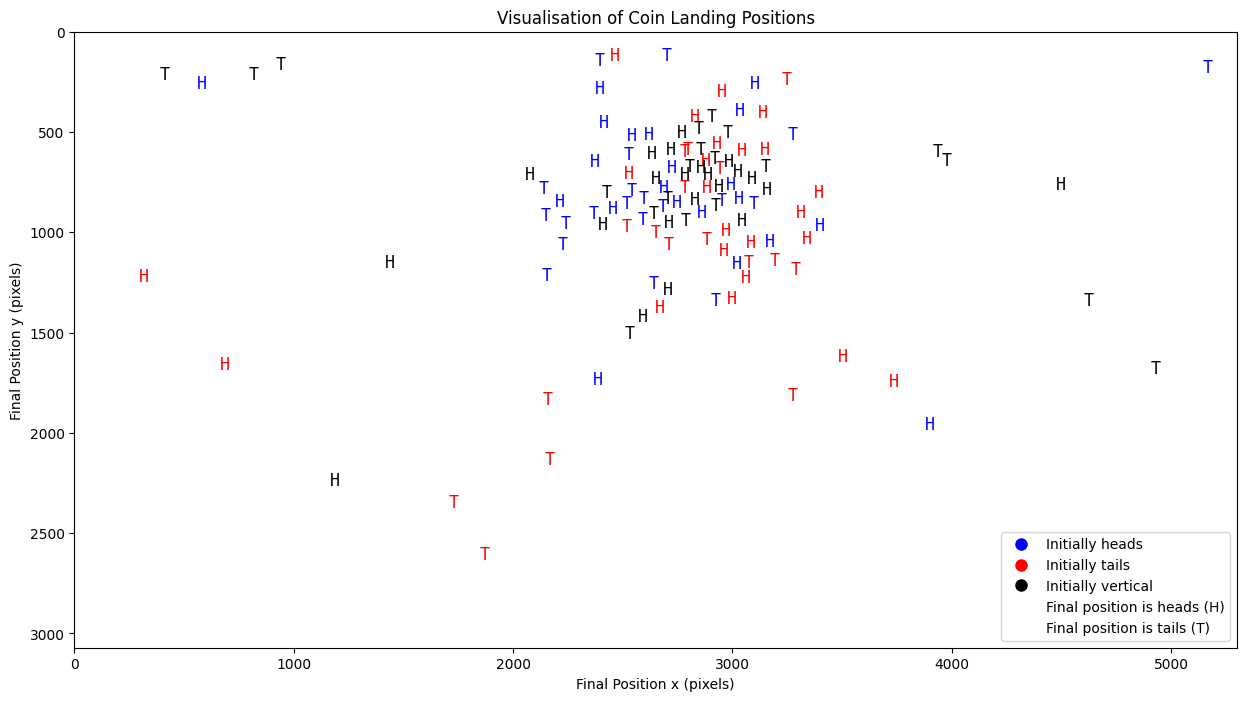

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
import os

# Load your data
# Make sure to update the path to where your CSV file is located
data_path = 'experiment_data.csv'
coin_data = pd.read_csv(data_path)

# Define the directory for saving the PDF
pdf_path = 'general_visualizations_of_data'

# Create the directory if it doesn't exist
os.makedirs(pdf_path, exist_ok=True)


# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(15, 8))

# Adjusting the axes limits to match the photo's pixel dimensions
ax.set_xlim(0, 5300)
ax.set_ylim(0, 3071)

# Inverting the y-axis to match the image coordinate system
ax.invert_yaxis()

# Color and label mapping
color_mapping = {'Tails': 'red', 'Heads': 'blue', 'Vertical': 'black'}
label_mapping = {'H': 'H', 'T': 'T'}

# Plotting each data point with the appropriate color and label as text
for _, row in coin_data.iterrows():
    ax.text(row['Final Position x'], row['Final Position y'], 
            label_mapping[row['Final Heads or Tails']], 
            color=color_mapping[row['Initial']], 
            fontsize=12, ha='center', va='center', family='monospace')

# Creating custom legends for initial conditions and final outcomes
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Initially heads', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Initially tails', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Initially vertical', markerfacecolor='black', markersize=10),
    Line2D([0], [0],  color='w', label='Final position is heads (H)', markerfacecolor='w', markeredgecolor='black', markersize=15),
    Line2D([0], [0],  color='w', label='Final position is tails (T)', markerfacecolor='w', markeredgecolor='black', markersize=15)
]

# Adding the legend to the plot
ax.legend(handles=legend_elements, loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Final Position x (pixels)')
ax.set_ylabel('Final Position y (pixels)')
ax.set_title('Visualisation of Coin Landing Positions')

# Save the plot as a PDF file
plt.savefig(f'{pdf_path}/coin_landing_positions.pdf')

# Display the plot
plt.show()

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score, roc_curve, auc, classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

# Define paths for saving the plots
classification_plot_path = 'classification_plots'
regression_plot_path = 'regression_plots'
general_visualizations_path = 'general_visualizations_of_folds'

# Create directories if they don't exist
os.makedirs(classification_plot_path, exist_ok=True)
os.makedirs(regression_plot_path, exist_ok=True)
os.makedirs(general_visualizations_path, exist_ok=True)

def visualize_data(y_reg, train, test, fold_no):
    plt.figure(figsize=(10, 8))

    # Visualize the normalized position data directly from y_reg
    plt.scatter(y_reg[train, 0], y_reg[train, 1], marker='x', color='black', label='Train Data')
    plt.scatter(y_reg[test, 0], y_reg[test, 1], marker='o', color='blue', label='Test Data')

    plt.title(f'Train vs Test Data Distribution - Fold {fold_no}')
    plt.xlabel('Final Position x (Normalized)')
    plt.ylabel('Final Position y (Normalized)')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.savefig(f'{general_visualizations_path}/train_test_data_fold_{fold_no}.pdf')
    plt.show()

def visualize_roc_curve(model, y_class, test, fold_no):
    # Obtain probabilistic outputs from the model for the test set
    y_pred_class_prob = model.predict(X[test])[0]

    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_class[test], y_pred_class_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='red', label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - Fold {fold_no}')
    plt.legend(loc="lower right")
    plt.savefig(f'{classification_plot_path}/roc_curve_fold_{fold_no}.pdf')
    plt.show()

def plot_regression_metrics(history, fold_no):
    # Plot MSE over epochs for both training and validation sets
    plt.figure(figsize=(10, 8))
    plt.plot(history.history['reg_output_mse'], color='red', label='Train MSE')
    plt.plot(history.history['val_reg_output_mse'], color='blue', label='Validation MSE')
    plt.title(f'Regression - MSE Over Epochs (Fold {fold_no})')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.savefig(f'{regression_plot_path}/mse_over_epochs_fold_{fold_no}.pdf')
    plt.show()

    
# Plotting Classification Accuracy Over Epochs
def plot_classification_accuracy(history, fold_no):
    plt.figure(figsize=(10, 8))
    plt.plot(history.history['class_output_accuracy'], color='red', label='Train Accuracy')
    plt.plot(history.history['val_class_output_accuracy'], color='blue', label='Validation Accuracy')
    plt.title(f'Classification - Accuracy Over Epochs (Fold {fold_no})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{classification_plot_path}/accuracy_over_epochs_fold_{fold_no}.pdf')
    plt.show()

# Plotting AUC Over Epochs
def plot_auc(history, fold_no):
    plt.figure(figsize=(10, 8))
    plt.plot(history.history['class_output_auc'], color='red', label='Train AUC')
    plt.plot(history.history['val_class_output_auc'], color='blue', label='Validation AUC')
    plt.title(f'Classification - AUC Over Epochs (Fold {fold_no})')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.savefig(f'{classification_plot_path}/auc_over_epochs_fold_{fold_no}.pdf')
    plt.show()

# Generating and Displaying Classification Report
def generate_classification_report(model, y_class, test, fold_no):
    y_pred_class_prob = model.predict(X[test])[0]
    y_pred_class = (y_pred_class_prob > 0.5).astype(int)
    class_report = classification_report(y_class[test], y_pred_class, target_names=['Heads', 'Tails'])
    print(f'Fold {fold_no} - Classification Report:\n{class_report}')

# Displaying Confusion Matrix
def print_confusion_matrix(model, X, y_class, test, fold_no):
    y_pred_class = (model.predict(X[test])[0] > 0.5).astype(int)
    cm = confusion_matrix(y_class[test], y_pred_class)
    print(f'Fold {fold_no} - Confusion Matrix:\n{cm}')


def compare_classification_predictions(model, X, y_class, test, fold_no):
    y_pred_class_prob = model.predict(X[test])[0]
    y_pred_class_keras = (y_pred_class_prob > 0.5).astype(int)

    # Decode the initial states from numeric to categorical
    initial_states = (X[test, 0].astype(int))

    manual_accuracy = np.mean(y_pred_class_keras == y_class[test])
    comparison = np.column_stack((initial_states, y_class[test], y_pred_class_keras, y_pred_class_prob))
    comparison_df = pd.DataFrame(comparison, columns=['Initial State', 'Actual Label', 'Predicted Label', 'Probabilistic Output'])

    print(f'Fold {fold_no} - Classification Predictions Comparison:\n{comparison_df.head(12)}')

    return comparison_df

def compare_regression_predictions(model, X, y_reg, test, scaler, fold_no):
    y_pred_reg = model.predict(X[test])[1]

    # Scale back the predictions to the original scale
    y_pred_reg_rescaled = scaler.inverse_transform(y_pred_reg)
    y_reg_rescaled = scaler.inverse_transform(y_reg[test])

    # Decode the initial states from numeric to categorical
    initial_states = (X[test, 0].astype(int))

    # Display side-by-side comparison
    comparison = np.column_stack((initial_states, y_reg_rescaled, y_pred_reg_rescaled))
    comparison_df = pd.DataFrame(comparison, columns=['Initial State', 'Actual X', 'Actual Y', 'Predicted X', 'Predicted Y'])
    
    print(f'\nFold {fold_no} - Creating the Regression Predictions Comparison Table...\n')
    print(f'Fold {fold_no} - Regression Predictions Comparison:\n', comparison_df.head(12))

    return comparison_df


2024-01-12 00:45:21.382009: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, roc_curve, auc, classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.metrics import AUC

plot_path = 'fold_4_visualisations_of_predictions'
os.makedirs(plot_path, exist_ok=True)

# Function to visualize regression comparisons one by one
def visualize_regression_comparisons(comparison_df, X, y_reg, test, scaler, fold_no):
    # Convert normalized regression targets back to pixel coordinates
    y_test_pixels = scaler.inverse_transform(y_reg[test])

    for i in range(len(comparison_df)):
        plt.figure(figsize=(10, 8))

        # Extract actual and predicted coordinates for the current instance
        actual_x, actual_y = comparison_df.iloc[i]['Actual X'], comparison_df.iloc[i]['Actual Y']
        predicted_x, predicted_y = comparison_df.iloc[i]['Predicted X'], comparison_df.iloc[i]['Predicted Y']
        
        # Plot all test data points with lower alpha
        plt.scatter(y_test_pixels[:, 0], y_test_pixels[:, 1], color='grey', alpha=0.5, label='Other Test Data')

        # Highlight the current point of interest
        plt.scatter(actual_x, actual_y, color='blue', label='Actual', zorder=5)
        plt.scatter(predicted_x, predicted_y, color='red', label='Predicted', zorder=5)

        plt.xlabel('X Position (pixels)')
        plt.ylabel('Y Position (pixels)')
        plt.title(f'Regression Prediction Comparison - Fold {fold_no}, Instance {i+1}')
        plt.xlim(0, 5300)
        plt.ylim(0, 3071)
        plt.gca().invert_yaxis()  # To match the original image coordinate system
        plt.legend()
        plt.savefig(f'{plot_path}/regression_comparison_fold_{fold_no}_instance_{i+1}.pdf')
        plt.show()

def visualize_classification_comparisons(comparison_df, fold_no):
    # Load images for heads and tails
    heads_img = mpimg.imread('coin_heads_tails/heads.jpg')
    tails_img = mpimg.imread('coin_heads_tails/tails.jpg')

    # Plotting the first few comparisons
    fig, axs = plt.subplots(nrows=comparison_df.shape[0], ncols=2, figsize=(5, 20))

    for i in range(comparison_df.shape[0]):
        actual_label = comparison_df.iloc[i]['Actual Label']
        predicted_label = comparison_df.iloc[i]['Predicted Label']

        axs[i, 0].imshow(heads_img if actual_label == 0 else tails_img)
        axs[i, 0].set_title(f"Actual: {'Heads' if actual_label == 0 else 'Tails'}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(heads_img if predicted_label == 0 else tails_img)
        axs[i, 1].set_title(f"Predicted: {'Heads' if predicted_label == 0 else 'Tails'}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.savefig(f'{plot_path}/classification_comparison_fold_{fold_no}.pdf')
    plt.show()



--- Processing Fold 1 ---
Creating the model...
Compiling the model (model.compile)...
Training the model (model.fit)...
Evaluating the model (model.evaluate)...


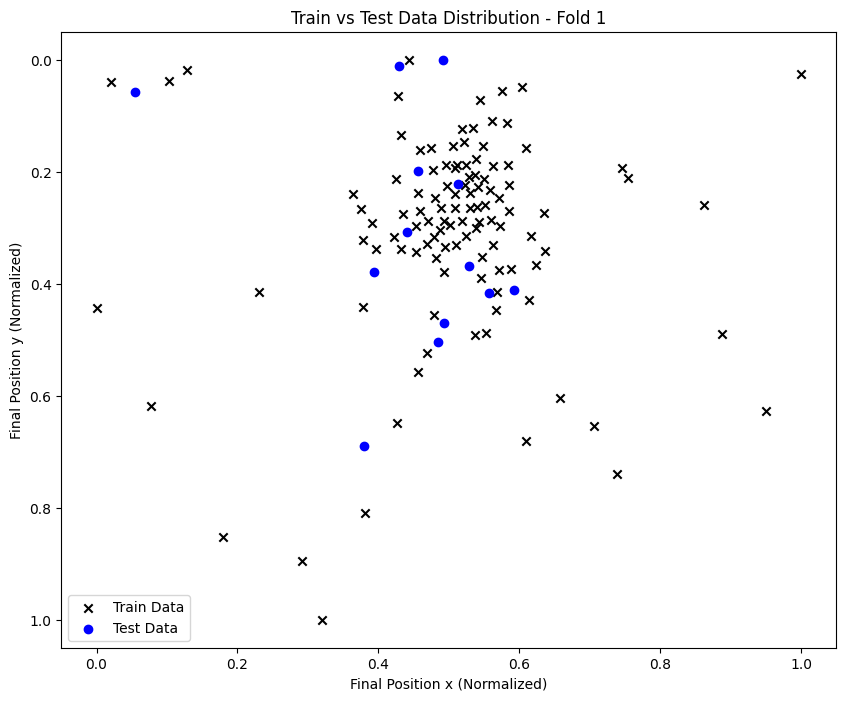

1/1 [==============================] - 0s 63ms/step


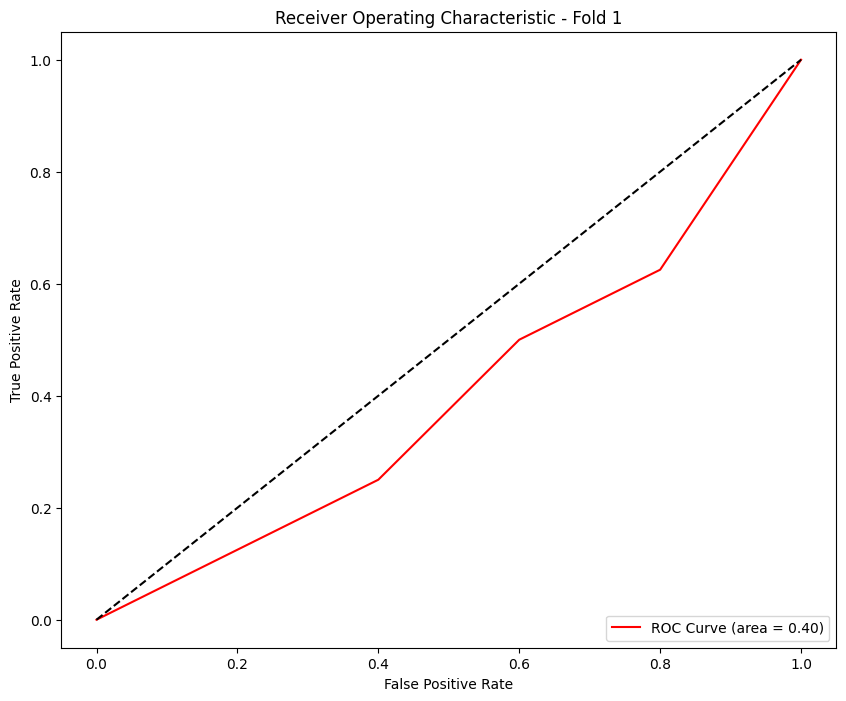

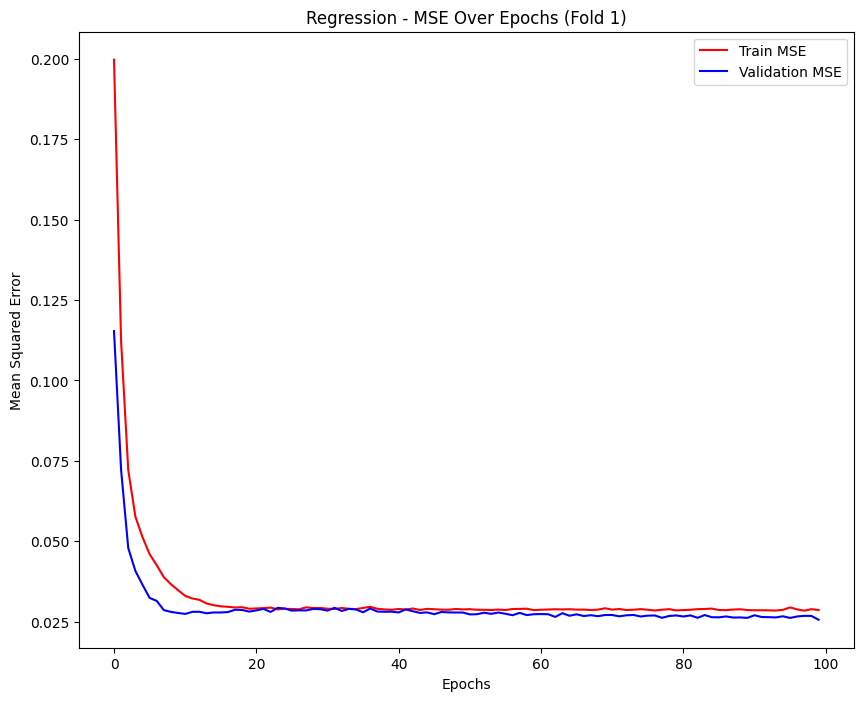

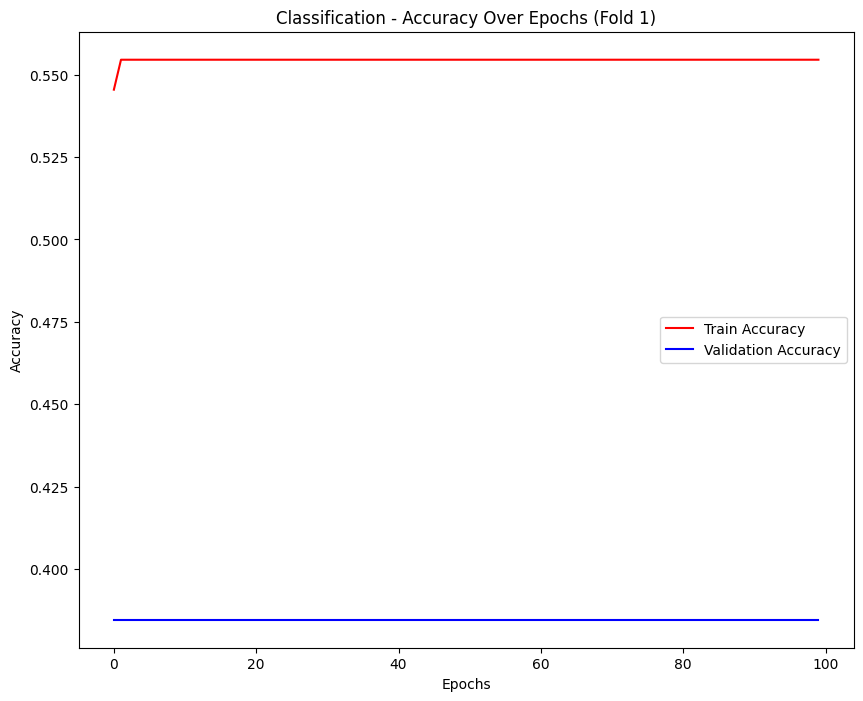

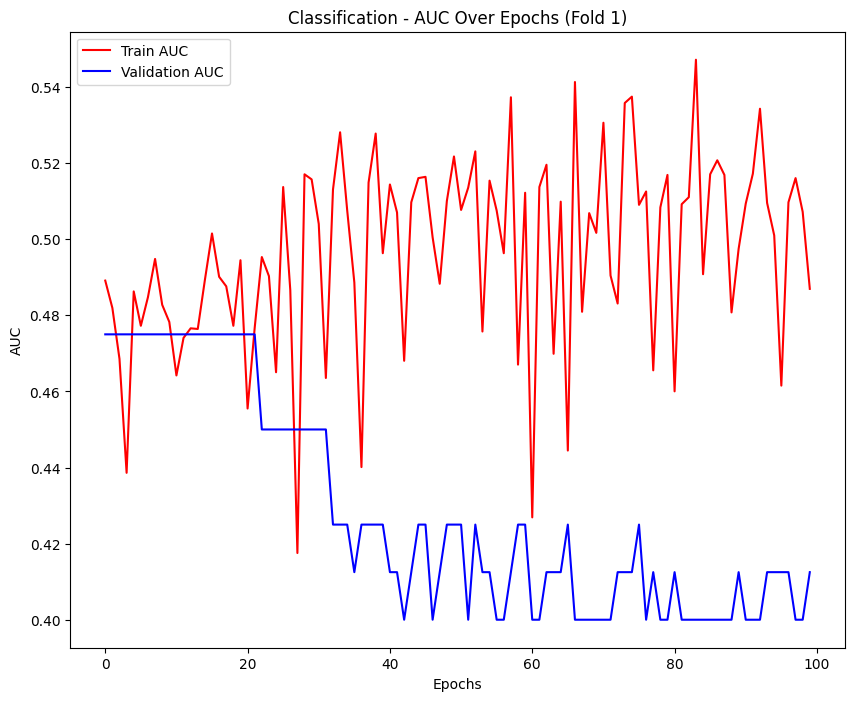

1/1 [==============================] - 0s 15ms/step
Fold 1 - Classification Report:
              precision    recall  f1-score   support

       Heads       0.38      1.00      0.56         5
       Tails       0.00      0.00      0.00         8

    accuracy                           0.38        13
   macro avg       0.19      0.50      0.28        13
weighted avg       0.15      0.38      0.21        13

1/1 [==============================] - 0s 14ms/step
Fold 1 - Confusion Matrix:
[[5 0]
 [8 0]]
1/1 [==============================] - 0s 14ms/step
Fold 1 - Classification Predictions Comparison:
    Initial State  Actual Label  Predicted Label  Probabilistic Output
0             1.0           1.0              0.0              0.419194
1             1.0           0.0              0.0              0.419194
2             1.0           1.0              0.0              0.419194
3             1.0           1.0              0.0              0.419194
4             0.0           0.0         

/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluating the model (model.evaluate)...


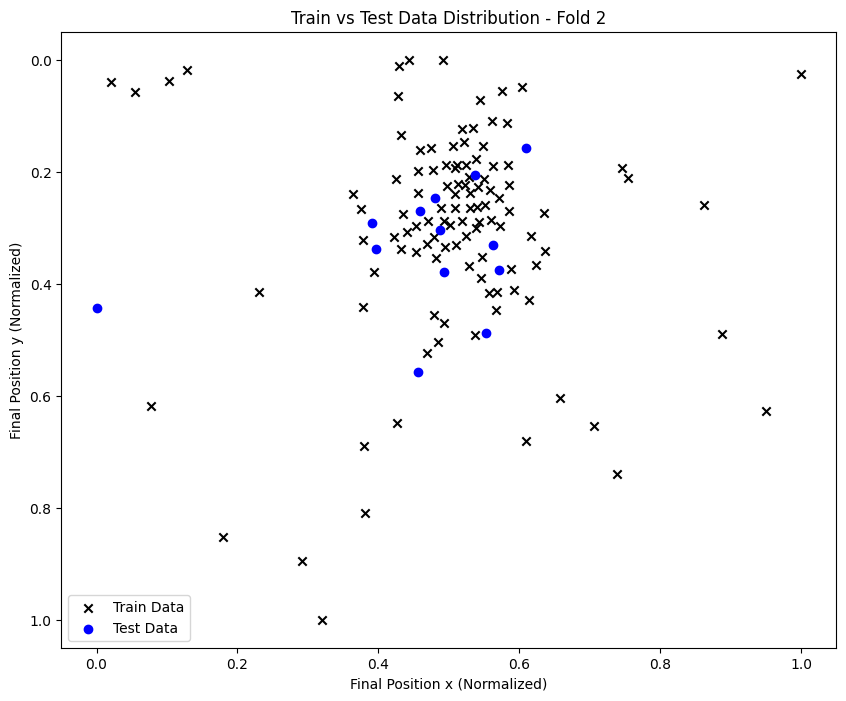

1/1 [==============================] - 0s 46ms/step


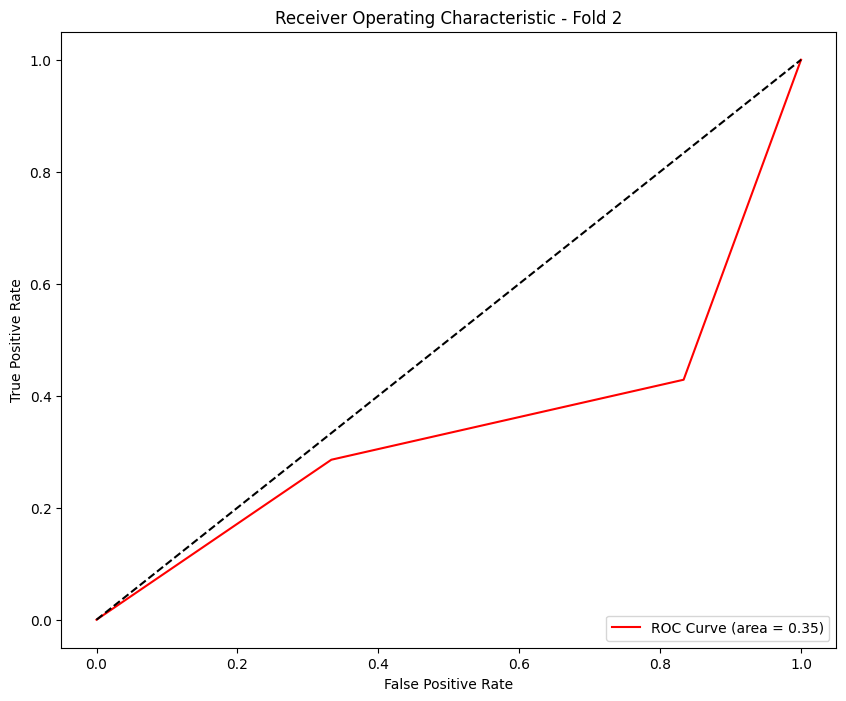

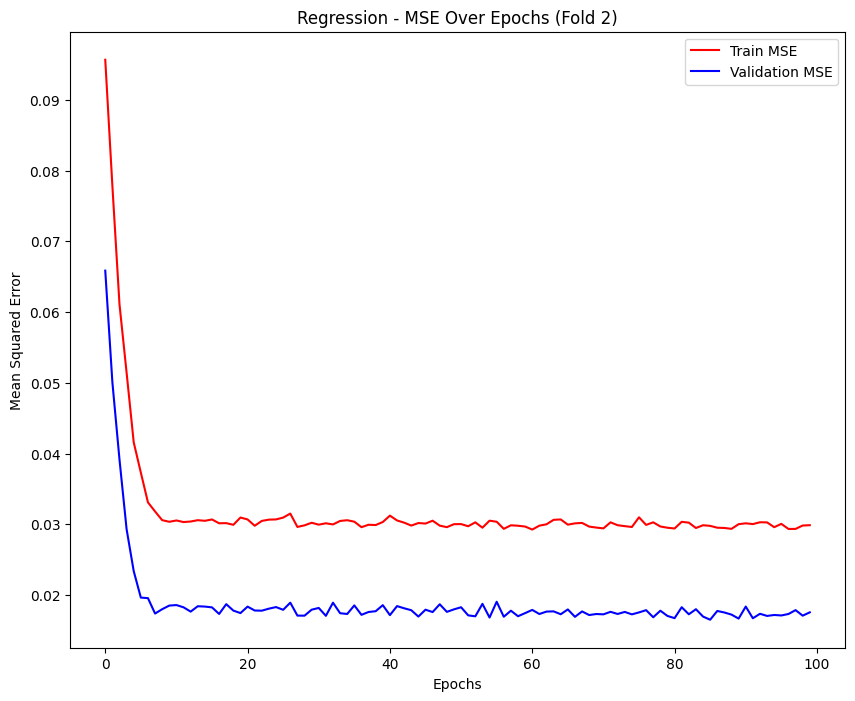

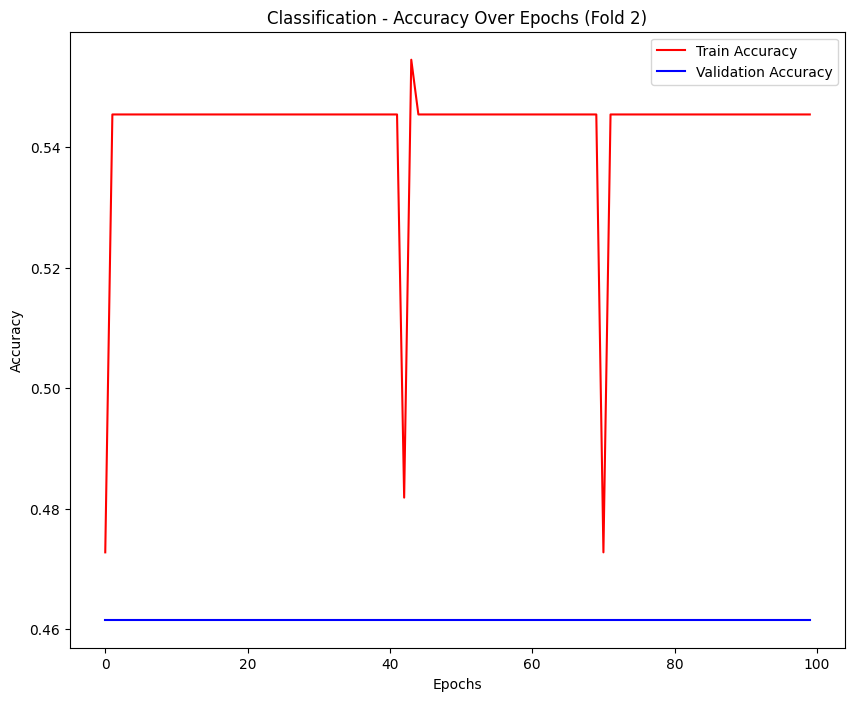

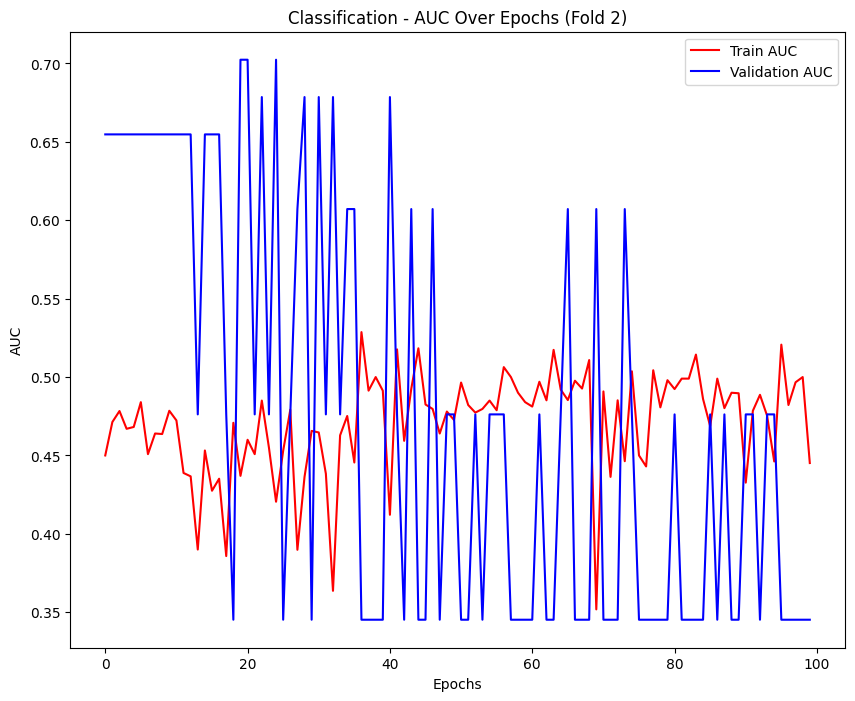

1/1 [==============================] - 0s 13ms/step
Fold 2 - Classification Report:
              precision    recall  f1-score   support

       Heads       0.46      1.00      0.63         6
       Tails       0.00      0.00      0.00         7

    accuracy                           0.46        13
   macro avg       0.23      0.50      0.32        13
weighted avg       0.21      0.46      0.29        13

1/1 [==============================] - 0s 12ms/step
Fold 2 - Confusion Matrix:
[[6 0]
 [7 0]]
1/1 [==============================] - 0s 13ms/step
Fold 2 - Classification Predictions Comparison:
    Initial State  Actual Label  Predicted Label  Probabilistic Output
0             1.0           0.0              0.0              0.453034
1             1.0           1.0              0.0              0.453034
2             1.0           0.0              0.0              0.453034
3             1.0           0.0              0.0              0.453034
4             0.0           0.0         

/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluating the model (model.evaluate)...


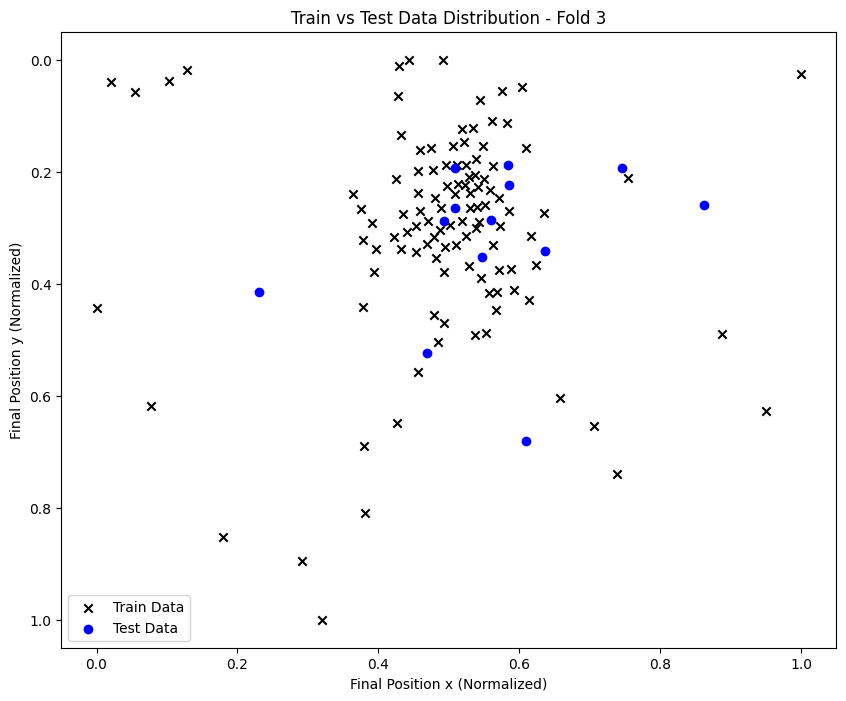

1/1 [==============================] - 0s 66ms/step


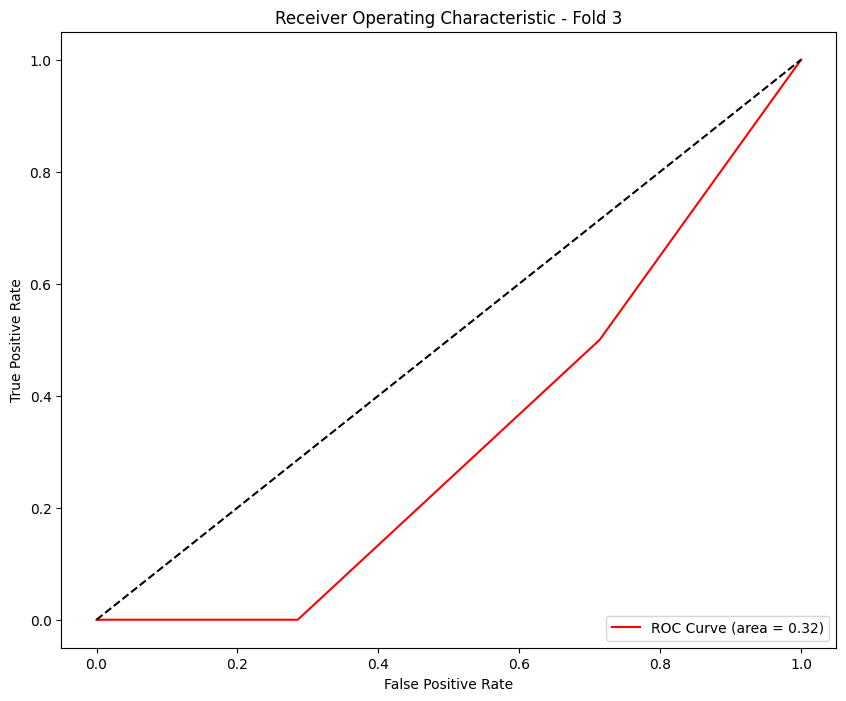

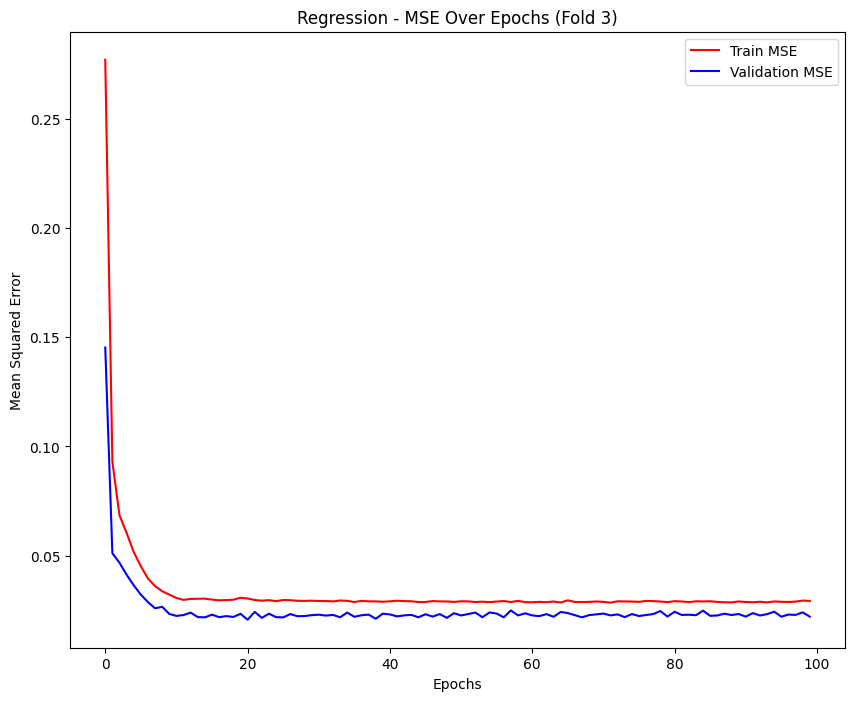

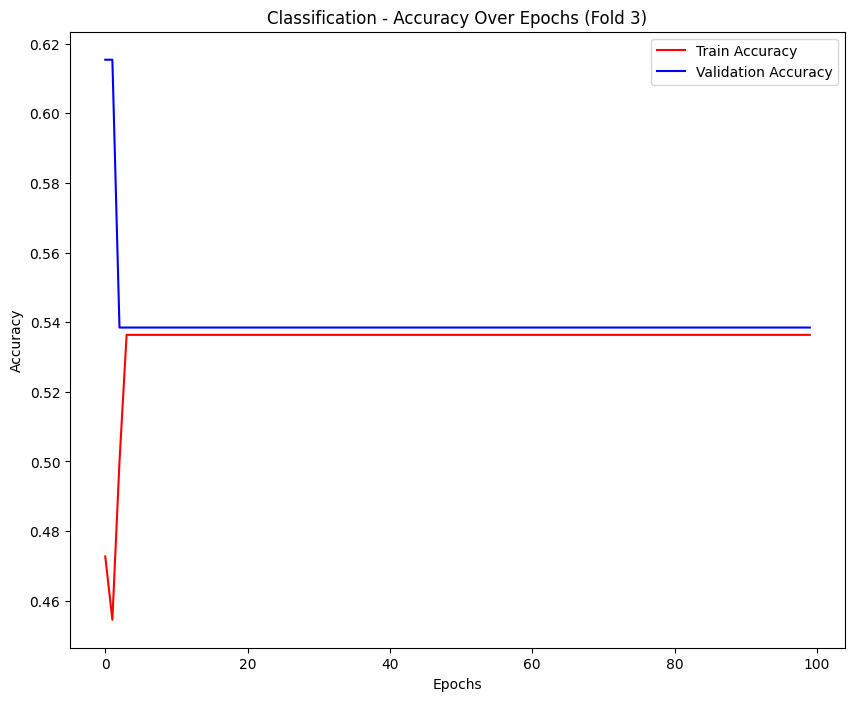

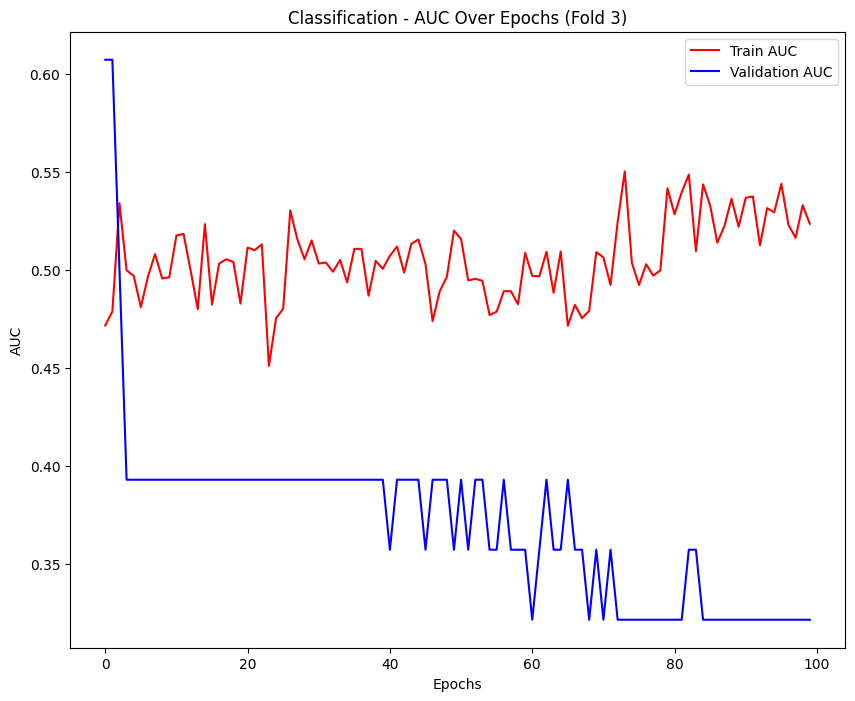

1/1 [==============================] - 0s 15ms/step
Fold 3 - Classification Report:
              precision    recall  f1-score   support

       Heads       0.54      1.00      0.70         7
       Tails       0.00      0.00      0.00         6

    accuracy                           0.54        13
   macro avg       0.27      0.50      0.35        13
weighted avg       0.29      0.54      0.38        13

1/1 [==============================] - 0s 15ms/step
Fold 3 - Confusion Matrix:
[[7 0]
 [6 0]]
1/1 [==============================] - 0s 15ms/step
Fold 3 - Classification Predictions Comparison:
    Initial State  Actual Label  Predicted Label  Probabilistic Output
0             1.0           1.0              0.0              0.441580
1             1.0           1.0              0.0              0.441580
2             1.0           0.0              0.0              0.441580
3             1.0           0.0              0.0              0.441580
4             1.0           1.0         

/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (model.fit)...
Evaluating the model (model.evaluate)...


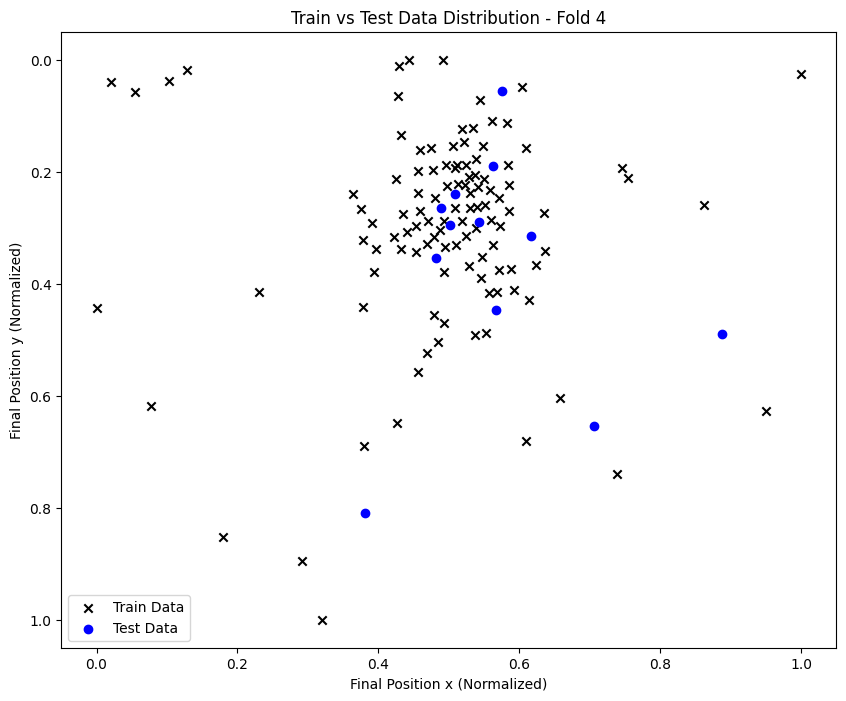

1/1 [==============================] - 0s 54ms/step


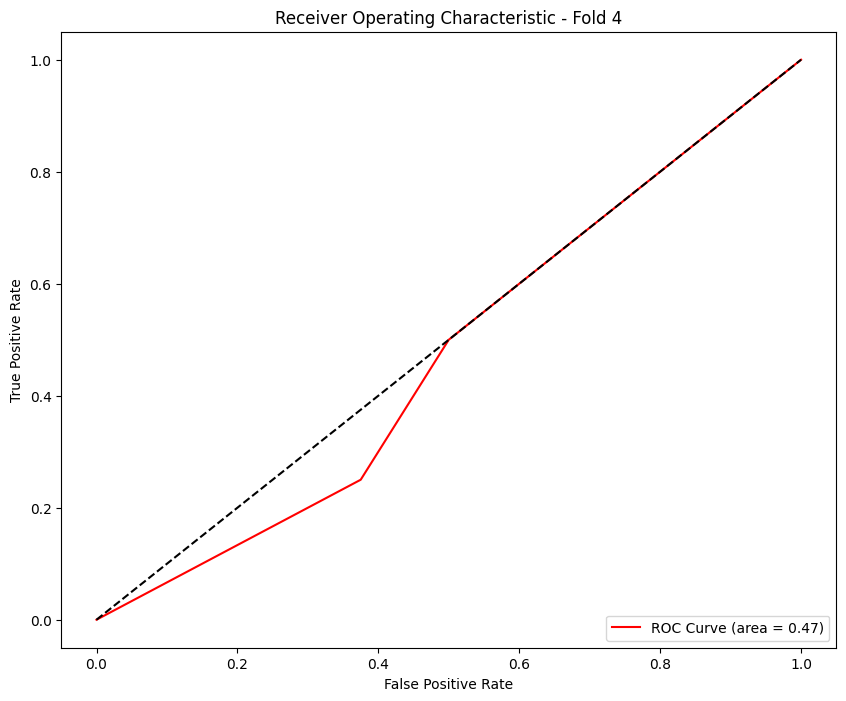

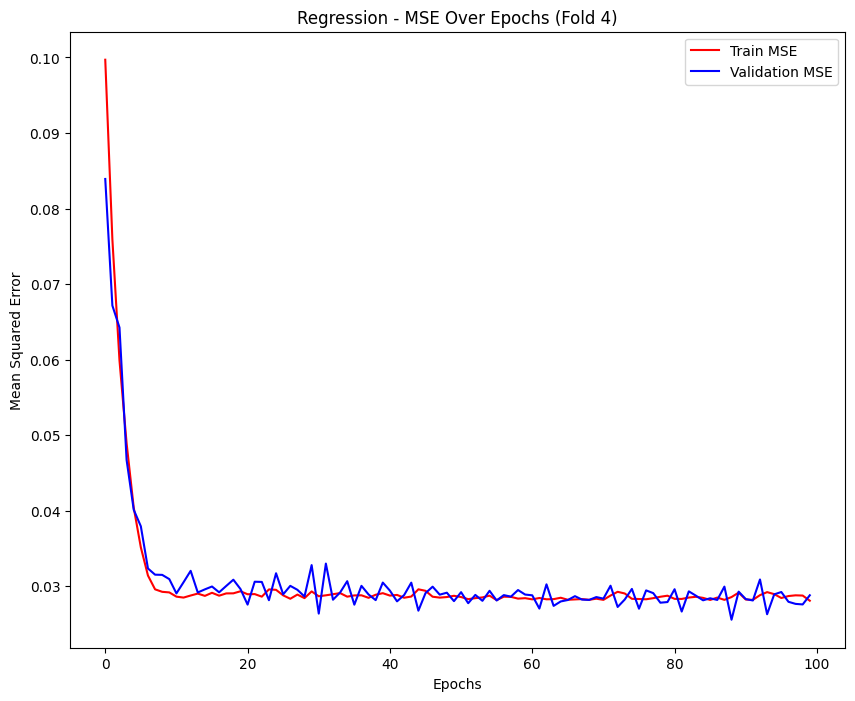

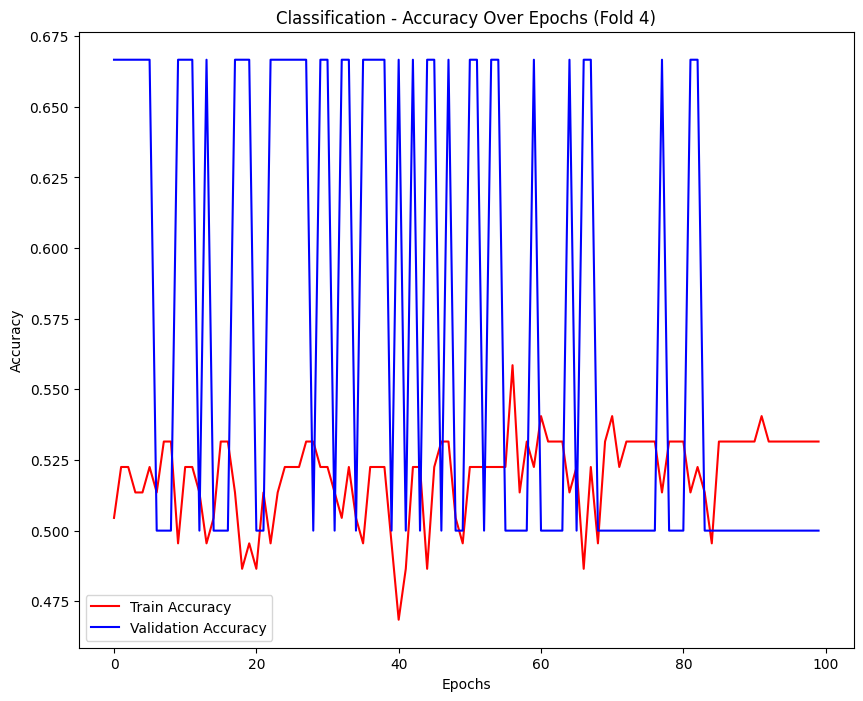

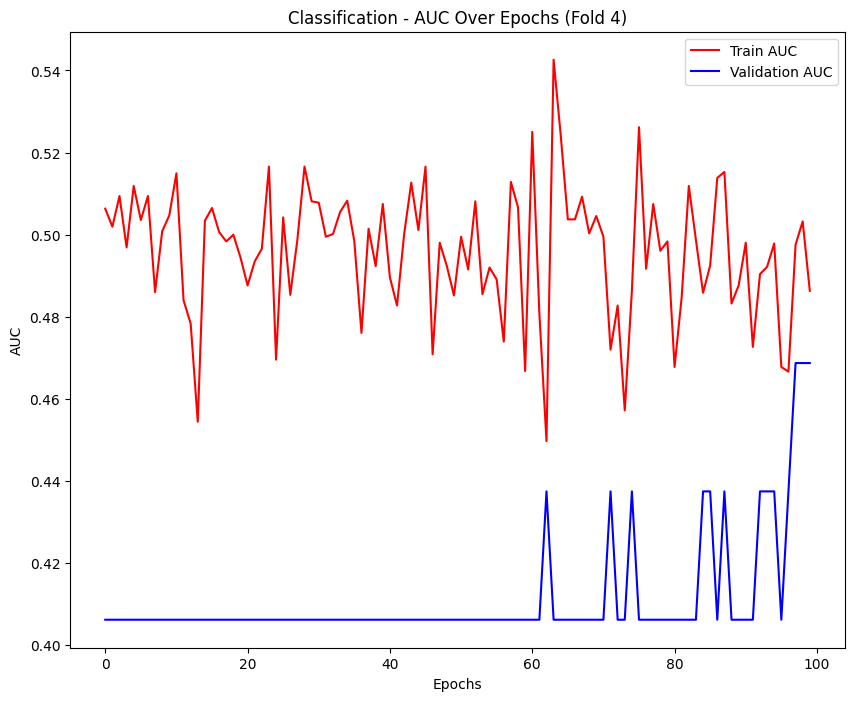

1/1 [==============================] - 0s 15ms/step
Fold 4 - Classification Report:
              precision    recall  f1-score   support

       Heads       0.62      0.62      0.62         8
       Tails       0.25      0.25      0.25         4

    accuracy                           0.50        12
   macro avg       0.44      0.44      0.44        12
weighted avg       0.50      0.50      0.50        12

1/1 [==============================] - 0s 14ms/step
Fold 4 - Confusion Matrix:
[[5 3]
 [3 1]]
1/1 [==============================] - 0s 15ms/step
Fold 4 - Classification Predictions Comparison:
    Initial State  Actual Label  Predicted Label  Probabilistic Output
0             1.0           1.0              0.0              0.467315
1             1.0           1.0              0.0              0.467315
2             1.0           0.0              0.0              0.467315
3             1.0           0.0              0.0              0.467315
4             1.0           0.0         

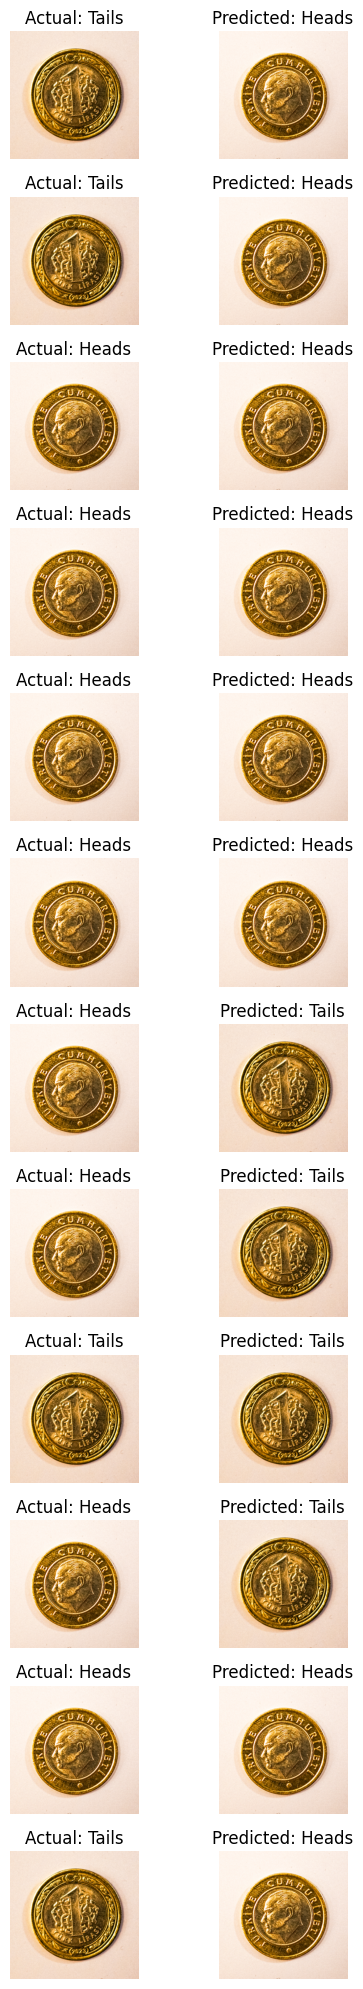

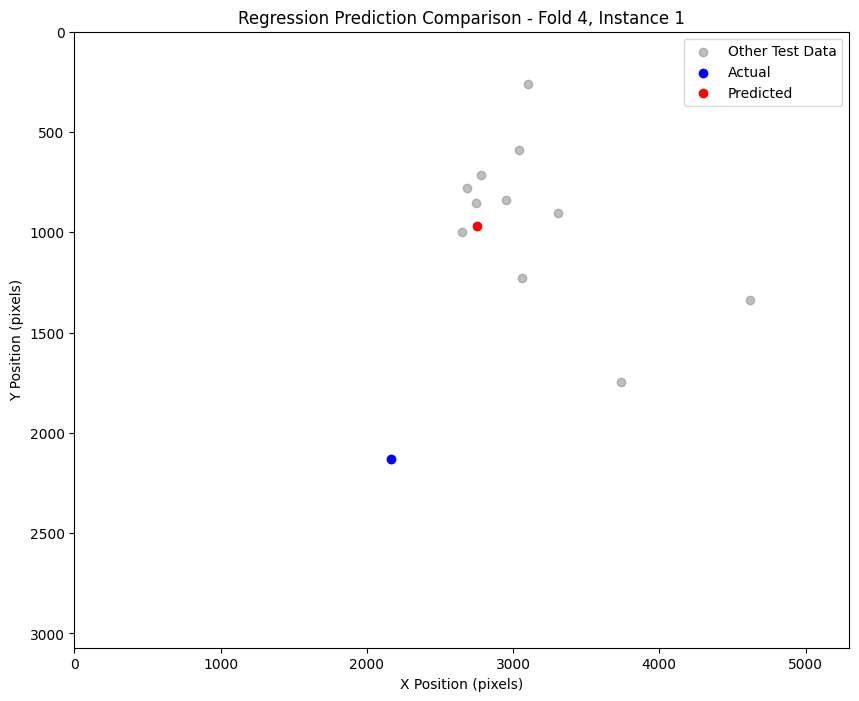

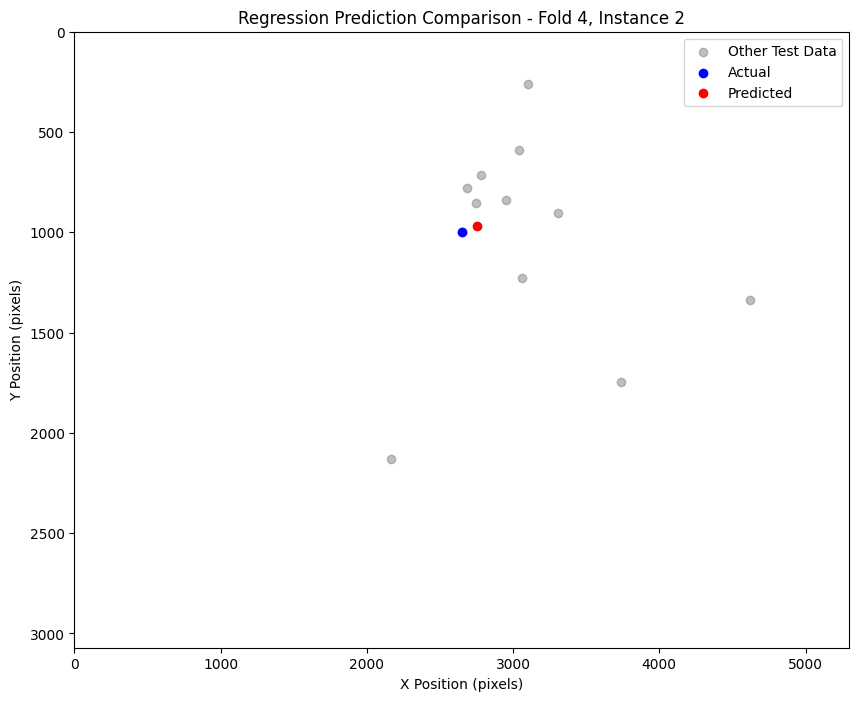

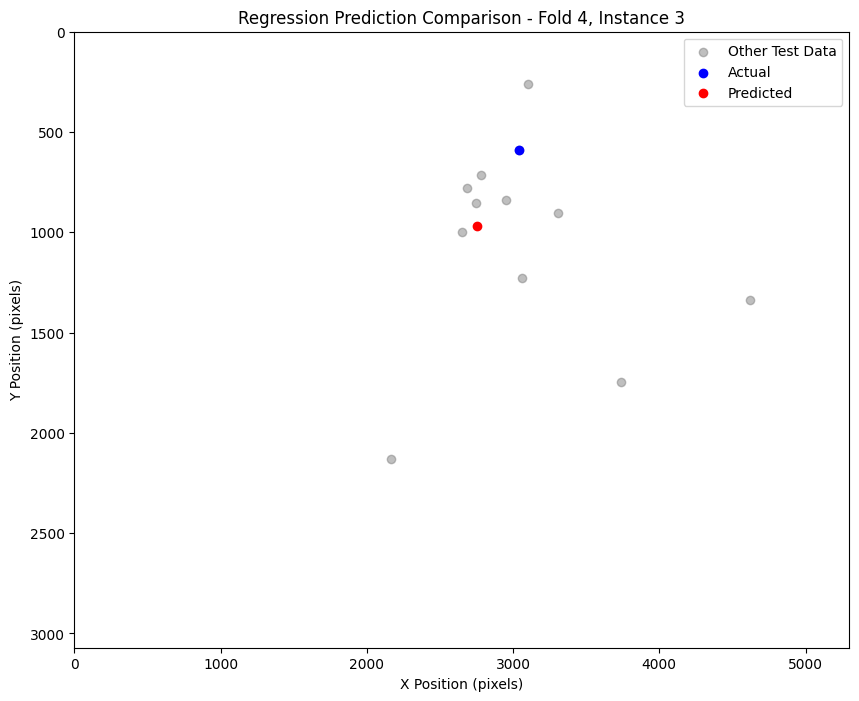

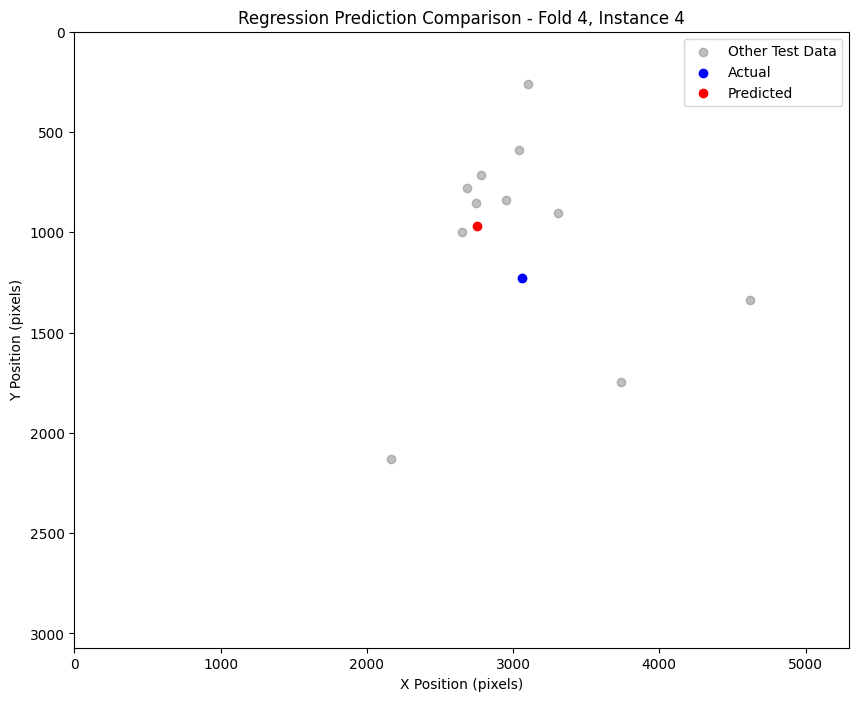

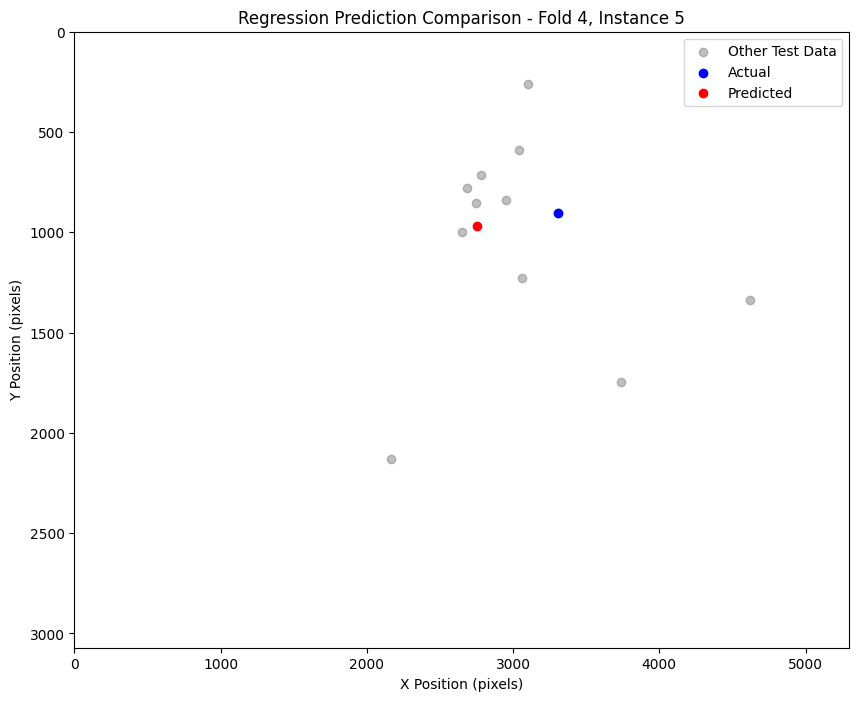

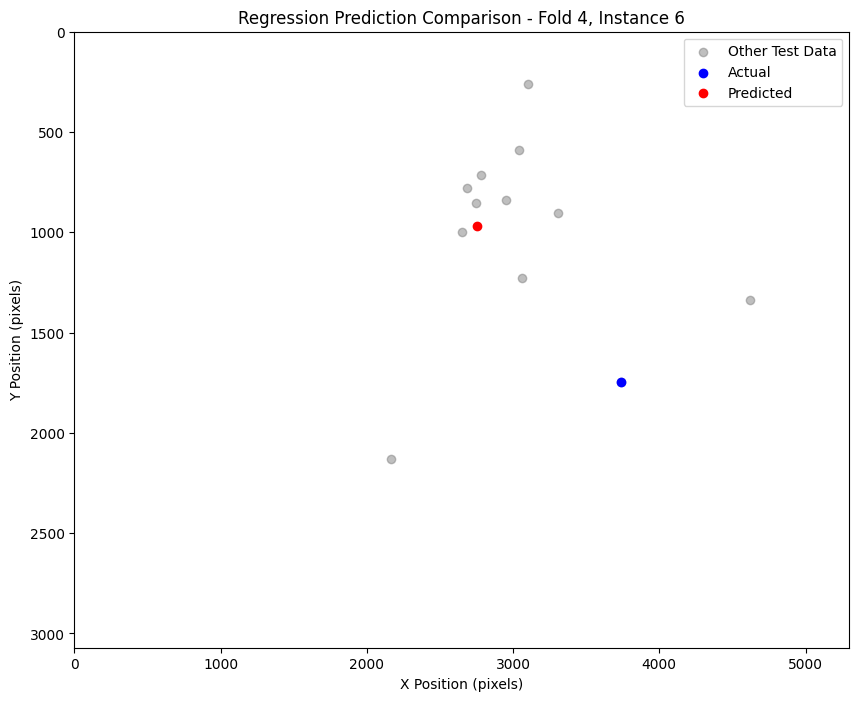

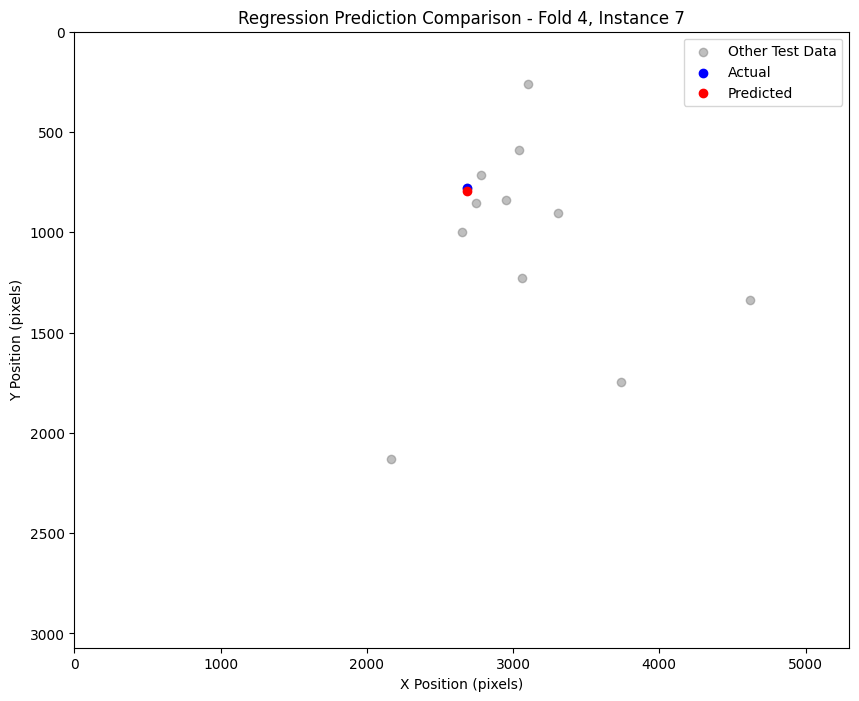

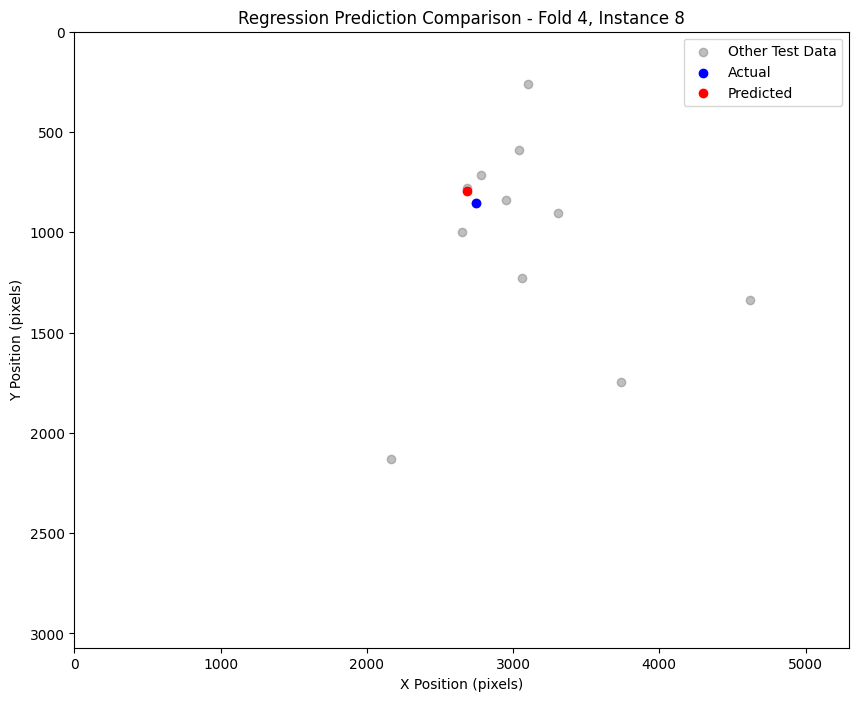

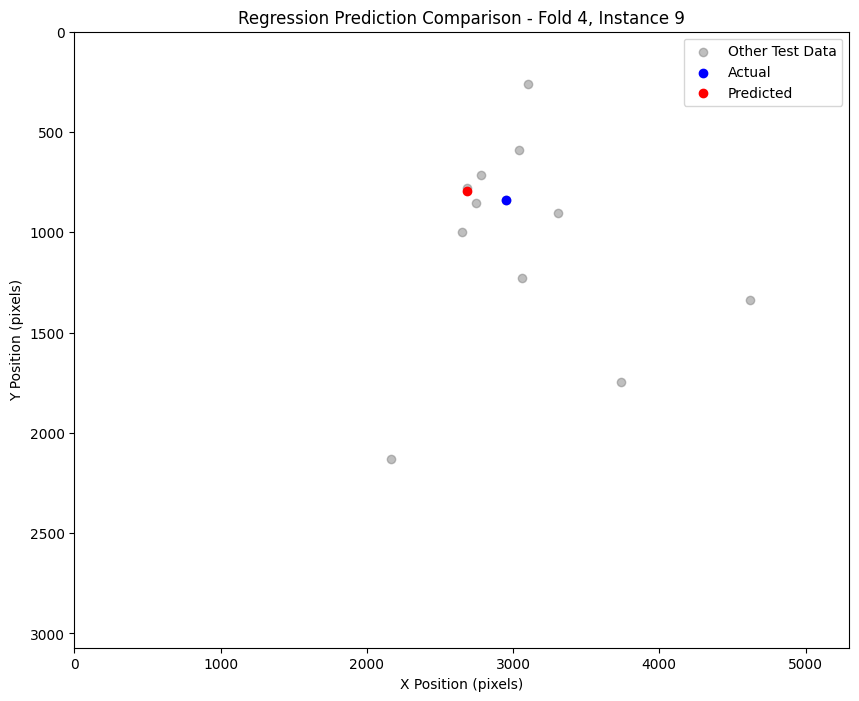

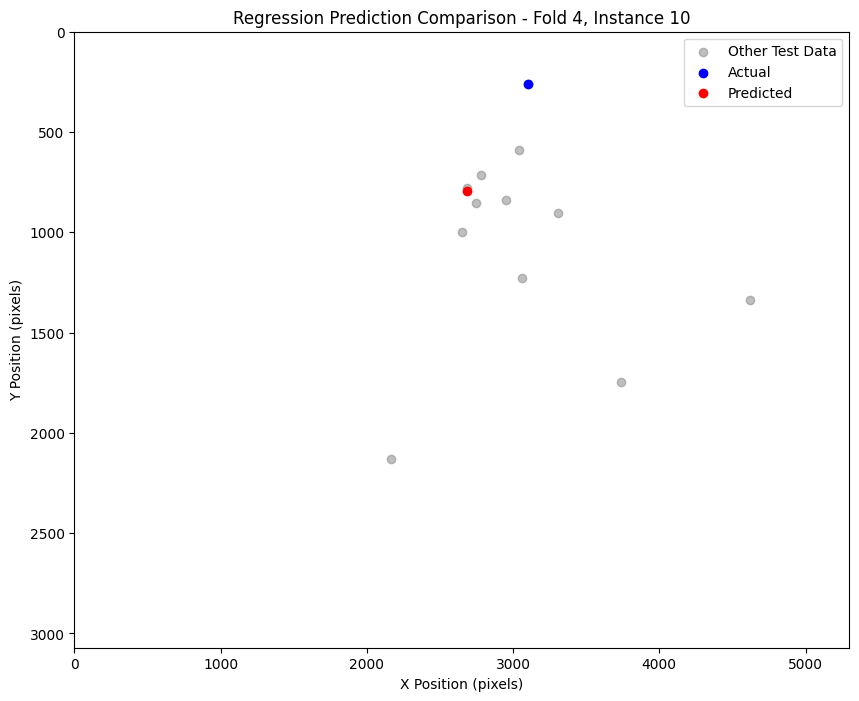

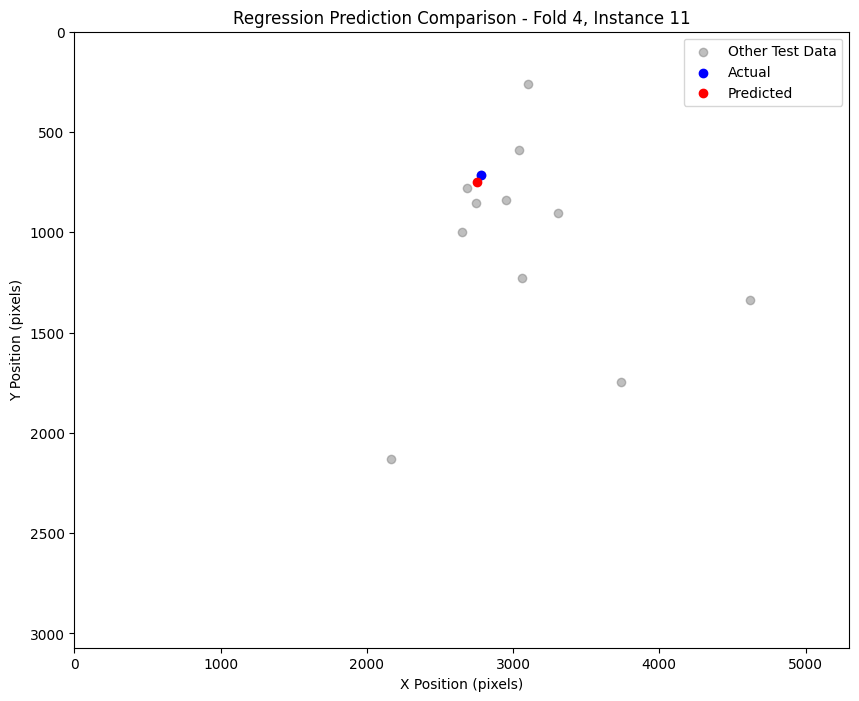

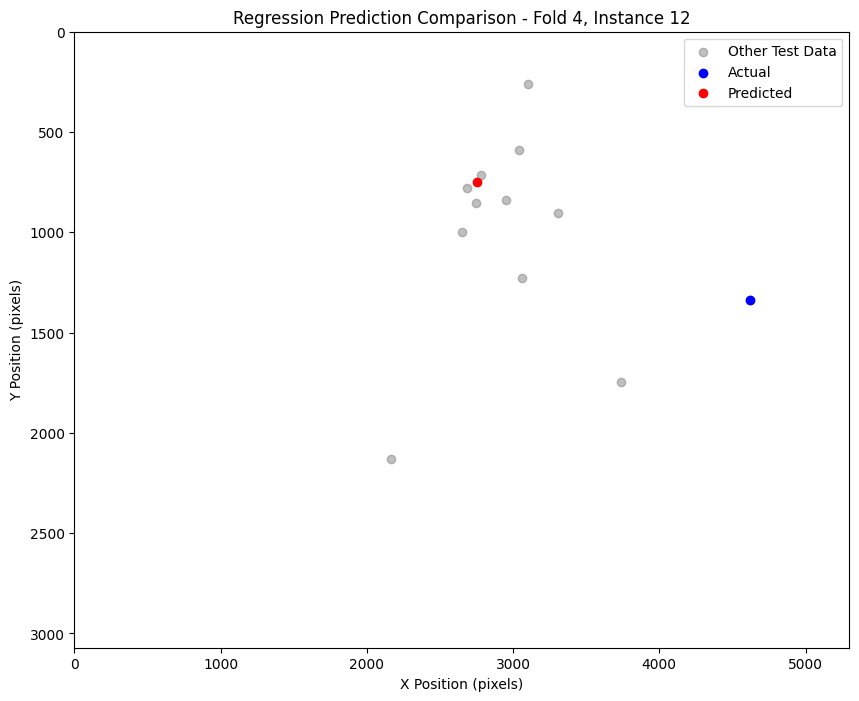


--- Processing Fold 5 ---
Creating the model...
Compiling the model (model.compile)...
Training the model (model.fit)...
Evaluating the model (model.evaluate)...


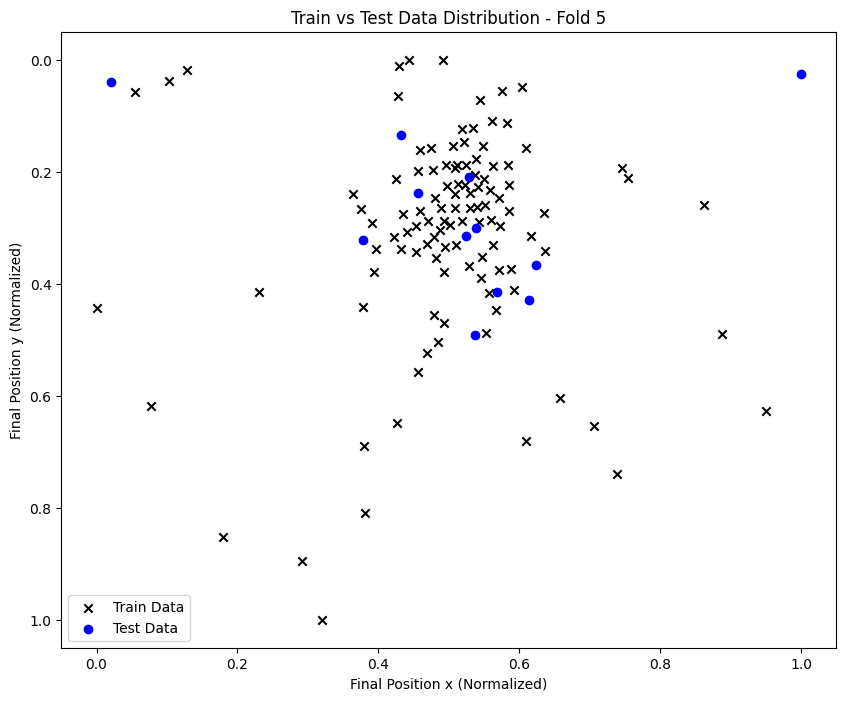

1/1 [==============================] - 0s 57ms/step


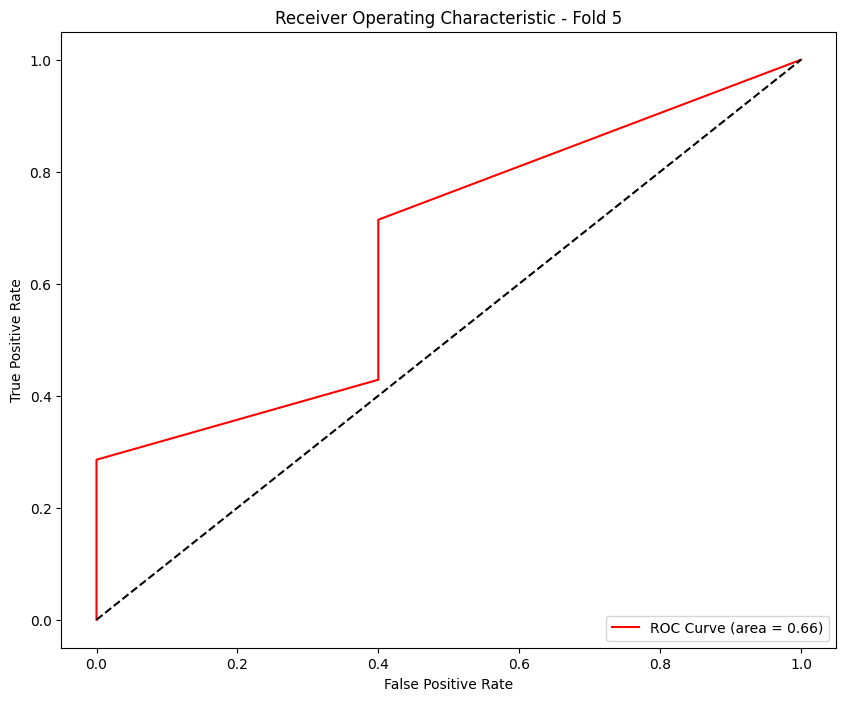

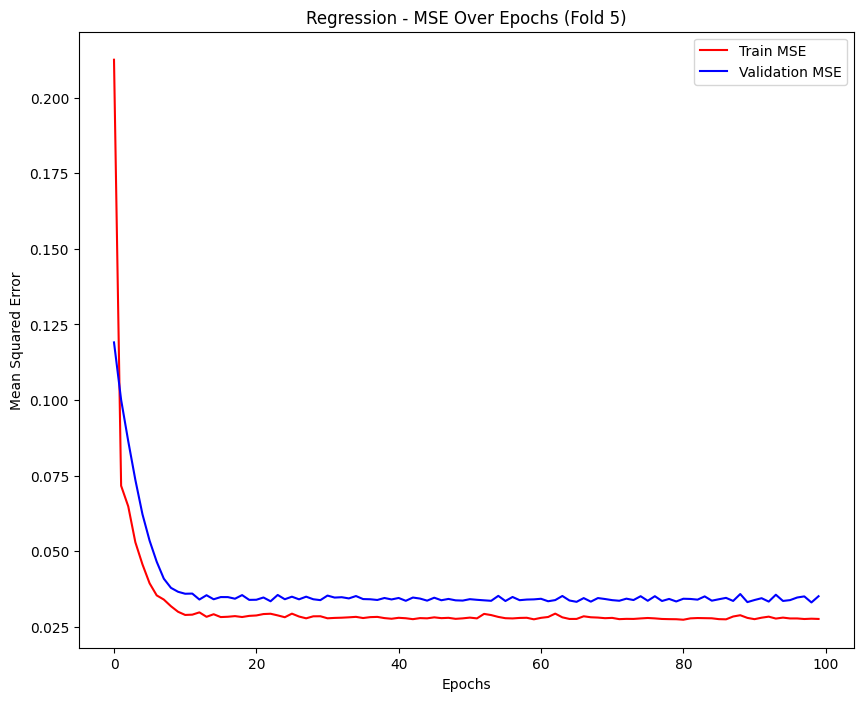

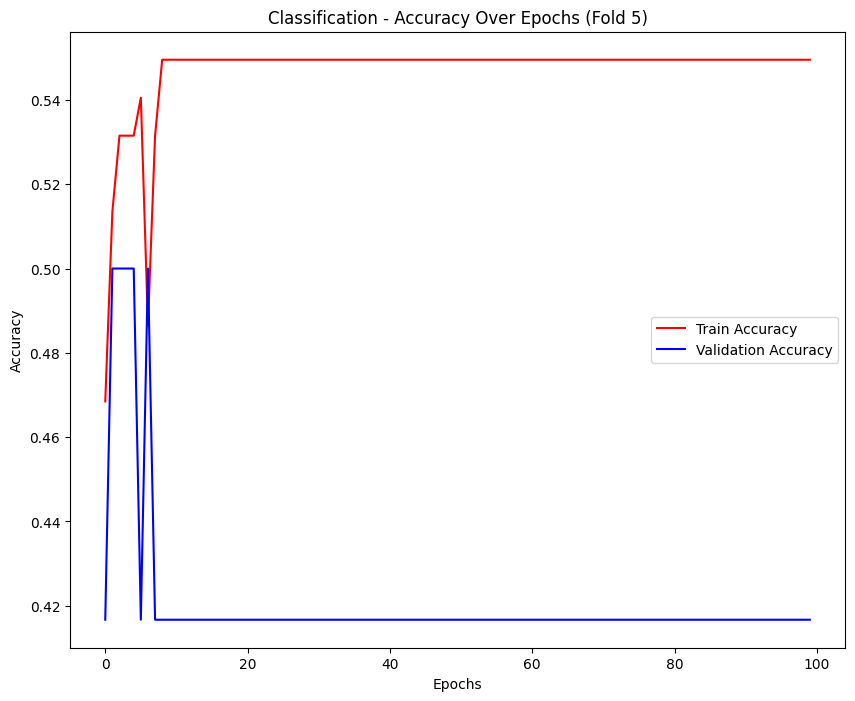

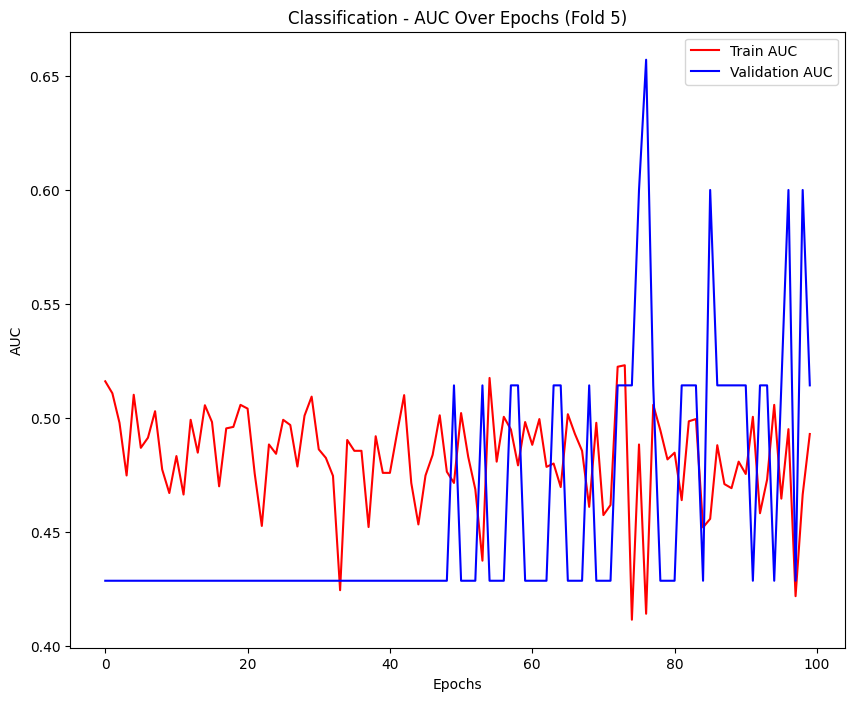

1/1 [==============================] - 0s 15ms/step
Fold 5 - Classification Report:
              precision    recall  f1-score   support

       Heads       0.42      1.00      0.59         5
       Tails       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

1/1 [==============================] - 0s 15ms/step
Fold 5 - Confusion Matrix:
[[5 0]
 [7 0]]
1/1 [==============================] - 0s 14ms/step
Fold 5 - Classification Predictions Comparison:
    Initial State  Actual Label  Predicted Label  Probabilistic Output
0             1.0           0.0              0.0              0.446357
1             1.0           0.0              0.0              0.446357
2             1.0           1.0              0.0              0.446357
3             1.0           0.0              0.0              0.446357
4             1.0           1.0         

/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (model.fit)...
Evaluating the model (model.evaluate)...


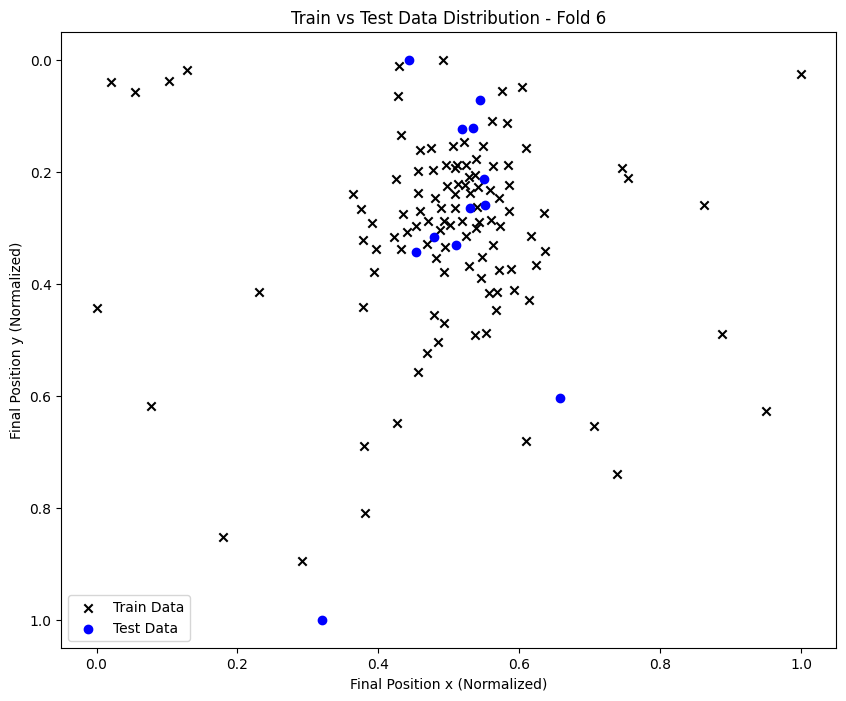

1/1 [==============================] - 0s 67ms/step


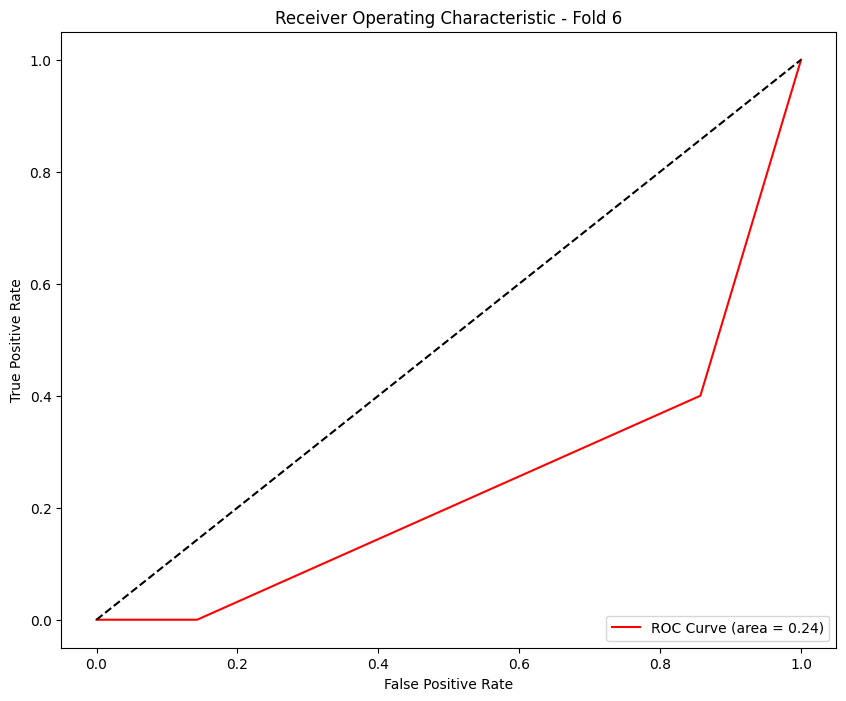

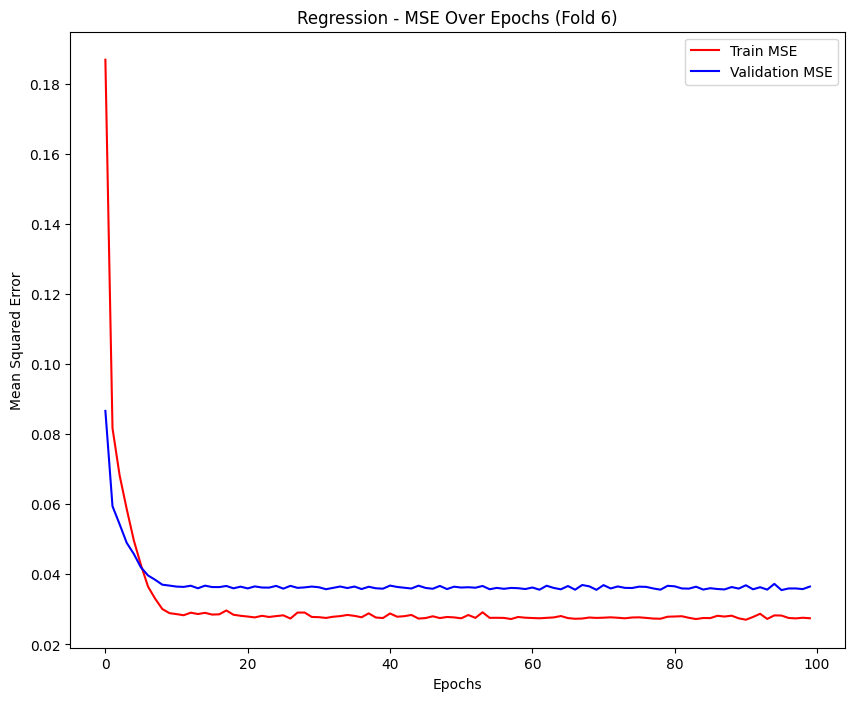

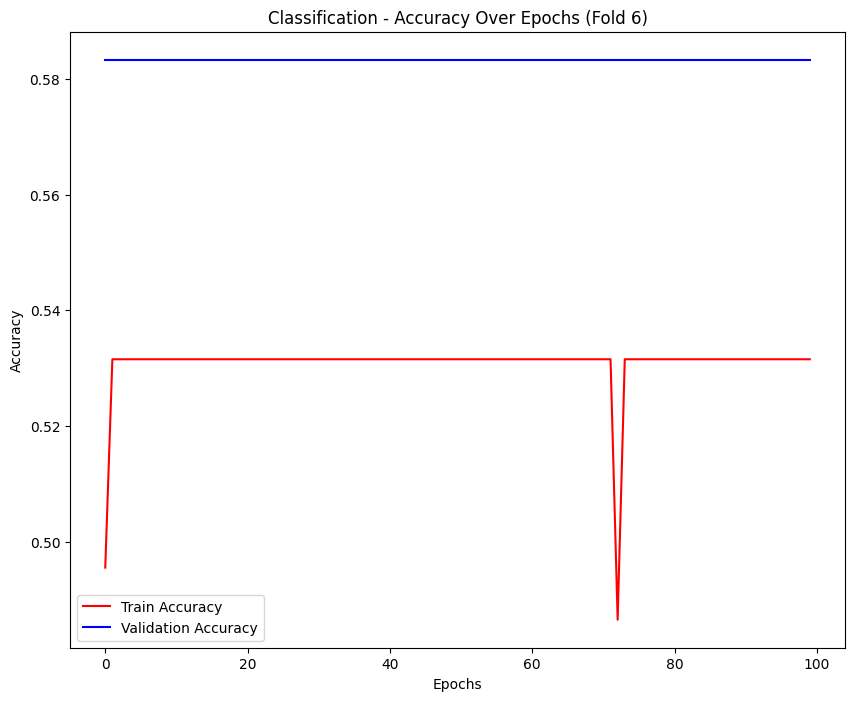

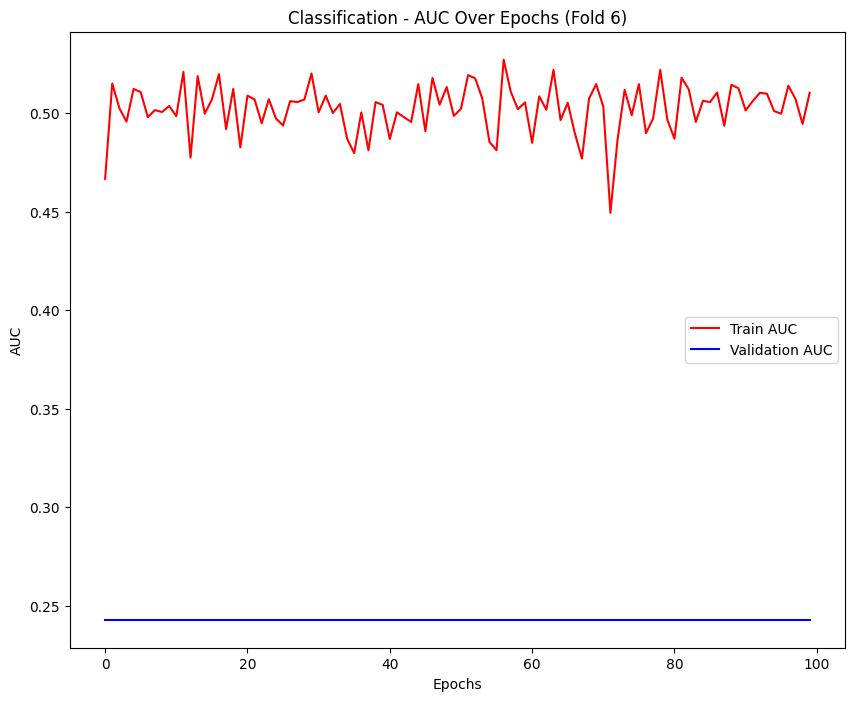

1/1 [==============================] - 0s 16ms/step
Fold 6 - Classification Report:
              precision    recall  f1-score   support

       Heads       0.58      1.00      0.74         7
       Tails       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

1/1 [==============================] - 0s 16ms/step
Fold 6 - Confusion Matrix:
[[7 0]
 [5 0]]
1/1 [==============================] - 0s 14ms/step
Fold 6 - Classification Predictions Comparison:
    Initial State  Actual Label  Predicted Label  Probabilistic Output
0             1.0           1.0              0.0              0.465180
1             1.0           0.0              0.0              0.465180
2             1.0           1.0              0.0              0.465180
3             1.0           0.0              0.0              0.465180
4             1.0           0.0         

/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluating the model (model.evaluate)...


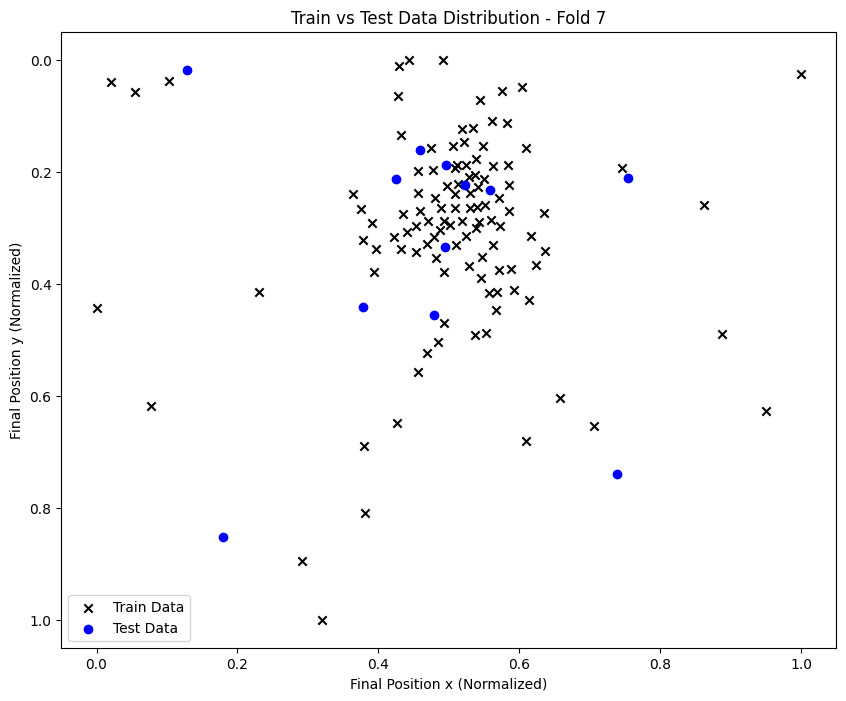

1/1 [==============================] - 0s 54ms/step


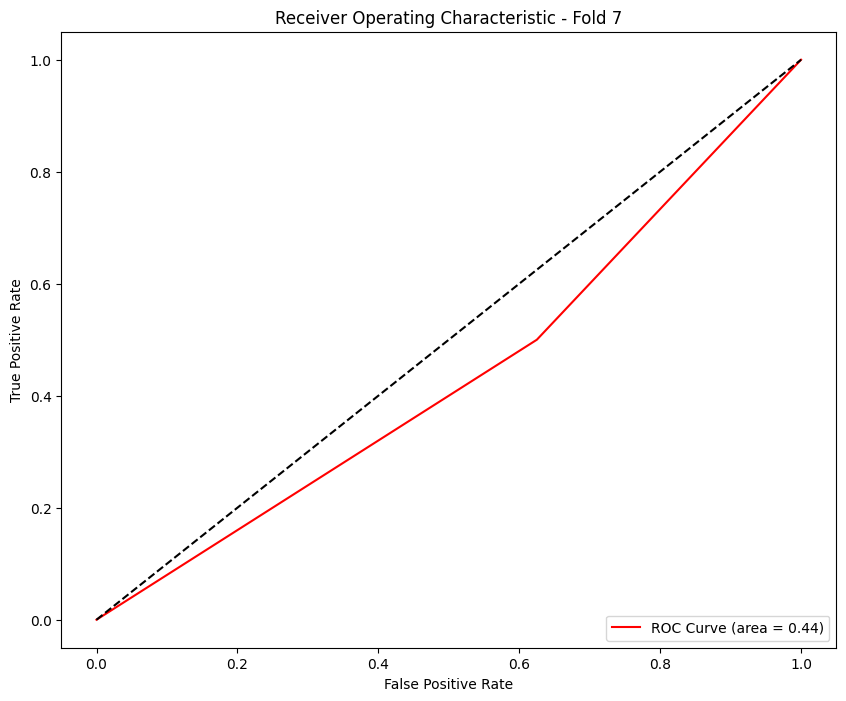

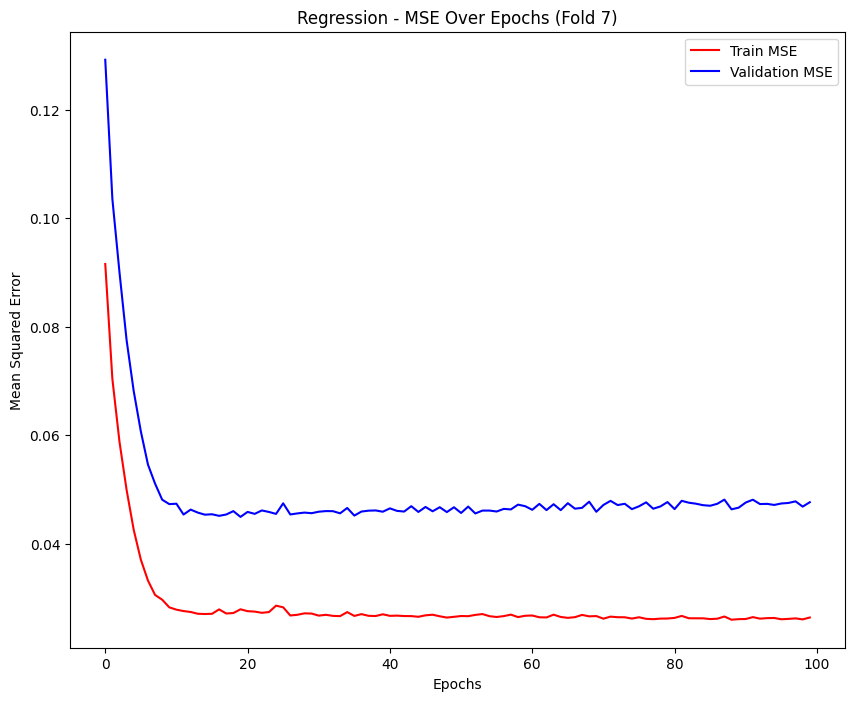

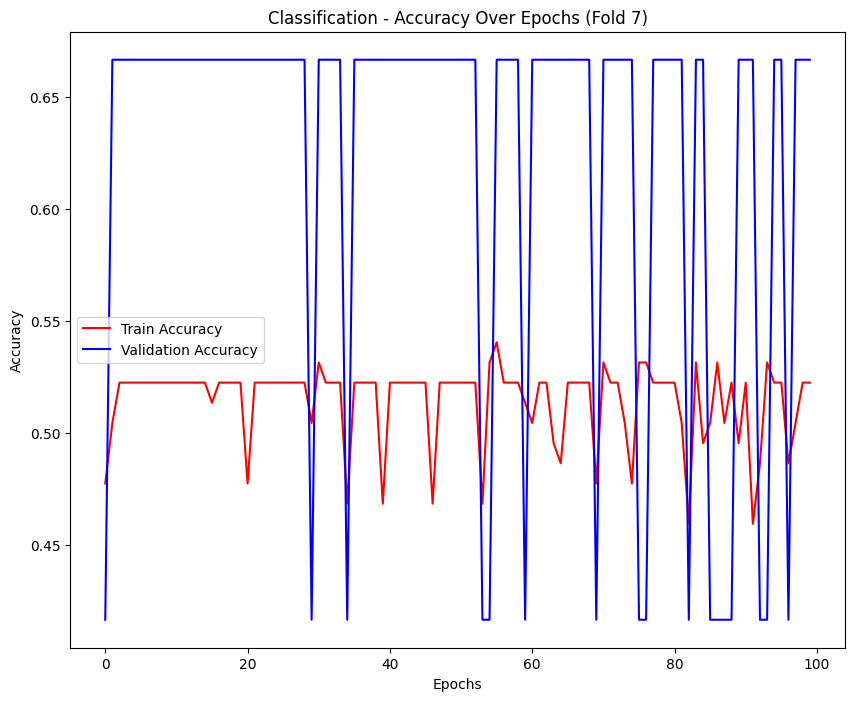

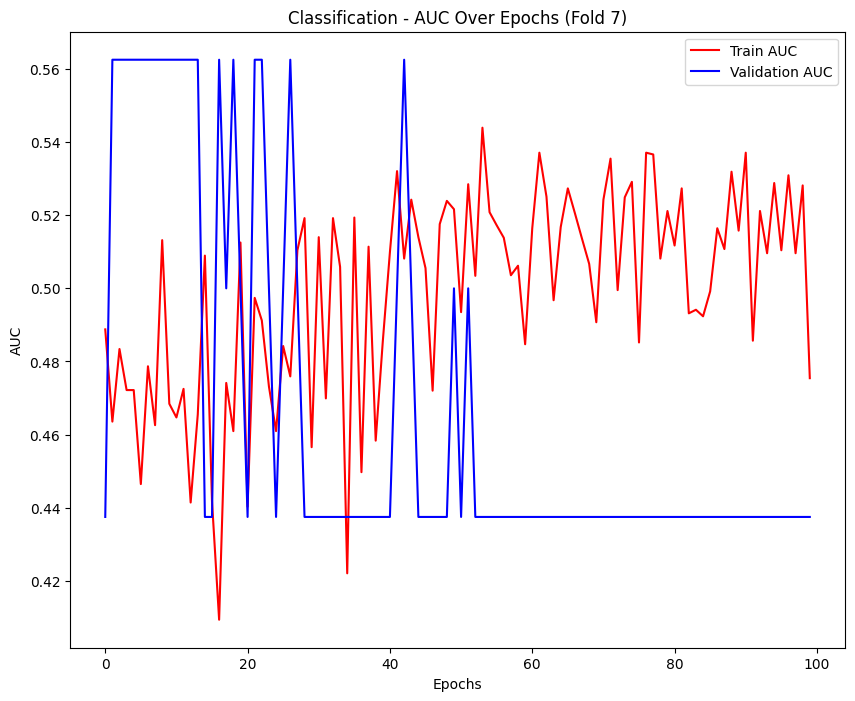

1/1 [==============================] - 0s 16ms/step
Fold 7 - Classification Report:
              precision    recall  f1-score   support

       Heads       0.67      1.00      0.80         8
       Tails       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12

1/1 [==============================] - 0s 14ms/step
Fold 7 - Confusion Matrix:
[[8 0]
 [4 0]]
1/1 [==============================] - 0s 14ms/step
Fold 7 - Classification Predictions Comparison:
    Initial State  Actual Label  Predicted Label  Probabilistic Output
0             0.0           1.0              0.0              0.475488
1             0.0           0.0              0.0              0.475488
2             0.0           0.0              0.0              0.475488
3             0.0           1.0              0.0              0.475488
4             0.0           0.0         

/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluating the model (model.evaluate)...


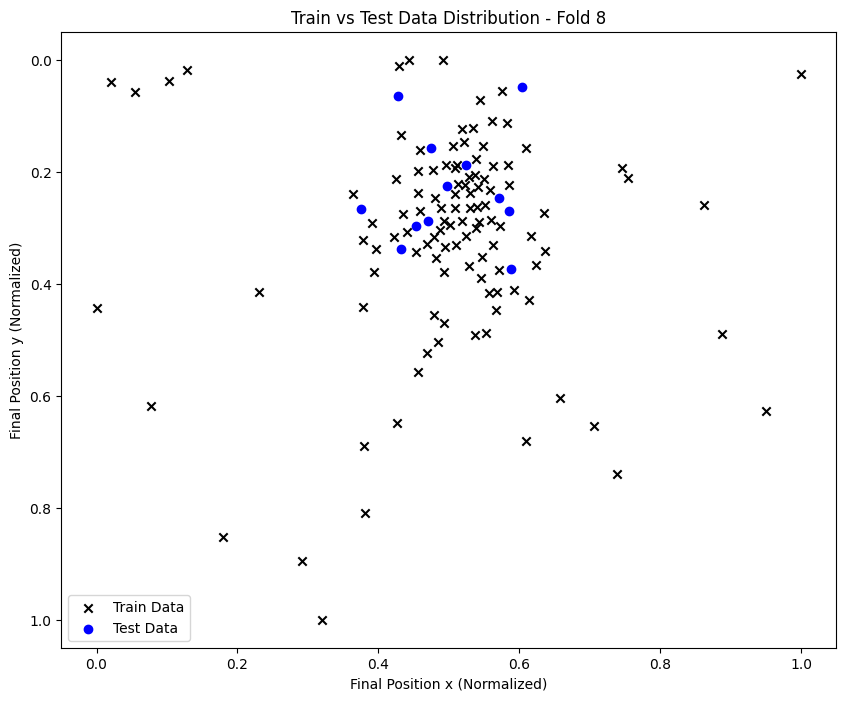

1/1 [==============================] - 0s 59ms/step


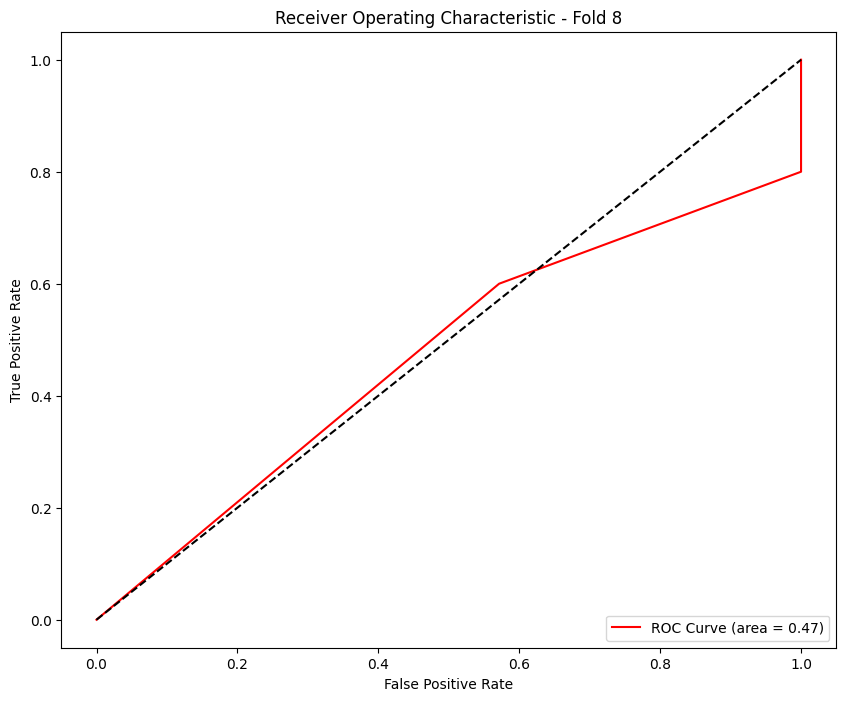

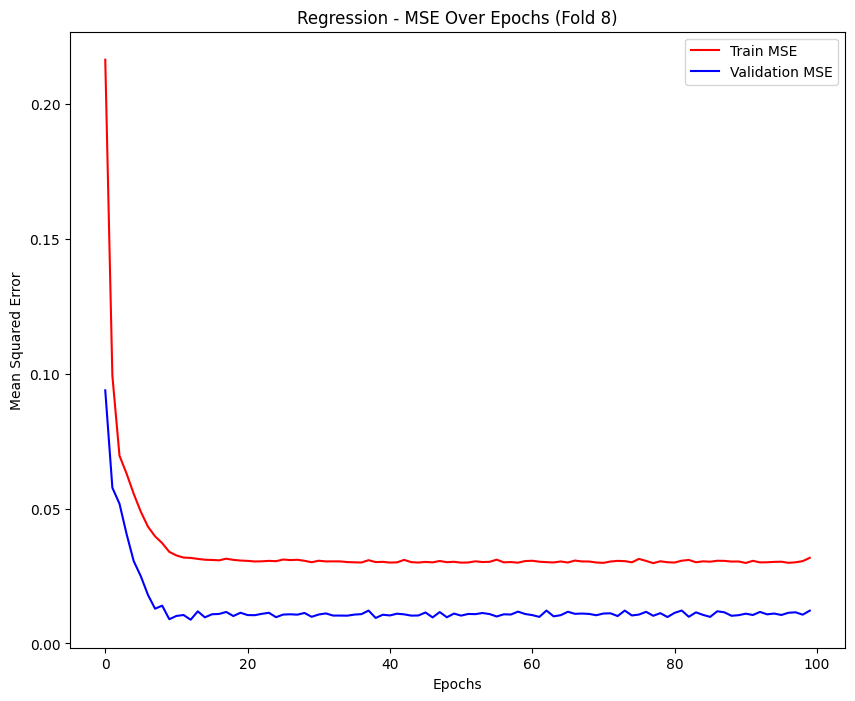

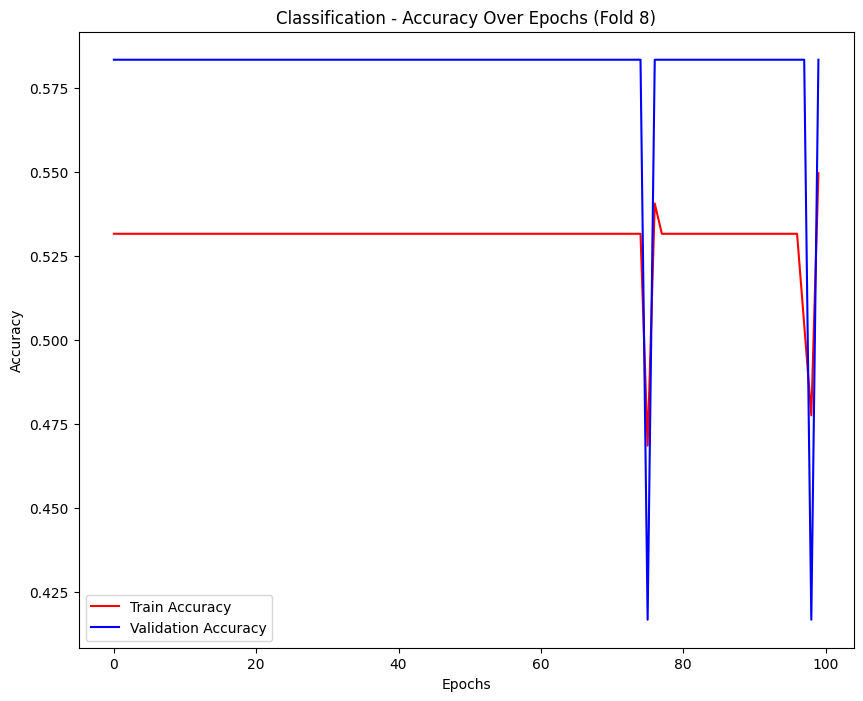

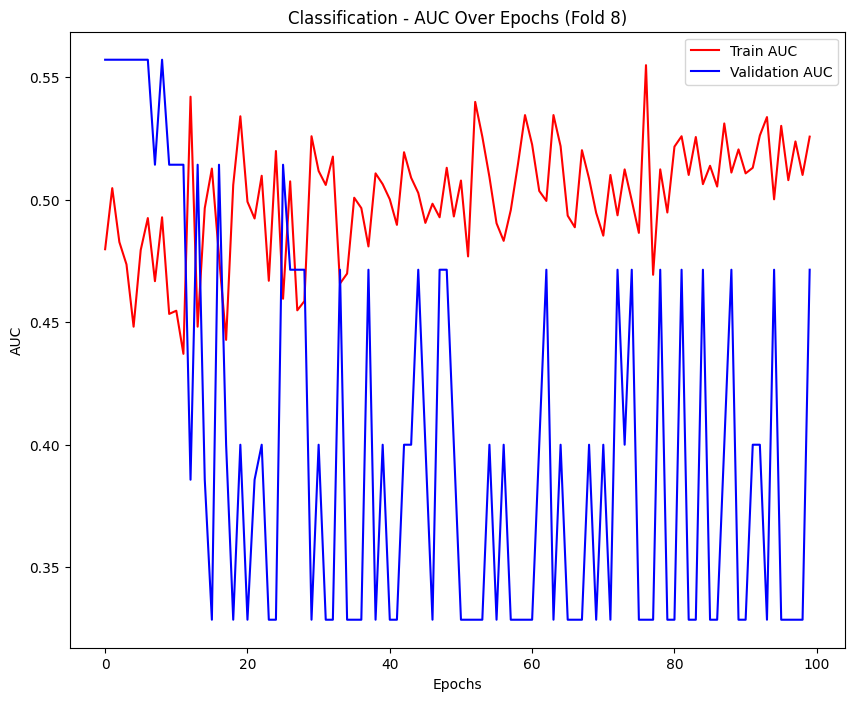

1/1 [==============================] - 0s 21ms/step
Fold 8 - Classification Report:
              precision    recall  f1-score   support

       Heads       0.58      1.00      0.74         7
       Tails       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

1/1 [==============================] - 0s 19ms/step
Fold 8 - Confusion Matrix:
[[7 0]
 [5 0]]
1/1 [==============================] - 0s 21ms/step
Fold 8 - Classification Predictions Comparison:
    Initial State  Actual Label  Predicted Label  Probabilistic Output
0             1.0           1.0              0.0              0.424029
1             0.0           1.0              0.0              0.479014
2             0.0           0.0              0.0              0.479014
3             0.0           1.0              0.0              0.479014
4             0.0           0.0         

/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 23ms/step

Fold 8 - Creating the Regression Predictions Comparison Table...

Fold 8 - Regression Predictions Comparison:
     Initial State  Actual X  Actual Y  Predicted X  Predicted Y
0             1.0    3247.0     240.0  2810.058350  1150.989136
1             0.0    2139.0     780.0  2711.463135   827.555725
2             0.0    2394.0     281.0  2711.463135   827.555725
3             0.0    2516.0     857.0  2711.463135   827.555725
4             0.0    2618.0     510.0  2711.463135   827.555725
5             0.0    2597.0     832.0  2711.463135   827.555725
6             0.0    2726.0     678.0  2711.463135   827.555725
7             0.0    3171.0    1046.0  2711.463135   827.555725
8             2.0    2409.0     959.0  2922.057861   927.176208
9             2.0    2856.0     587.0  2922.057861   927.176208
10            2.0    3089.0     731.0  2922.057861   927.176208
11            2.0    3155.0     788.0  2922.057861   927.176208

Sco

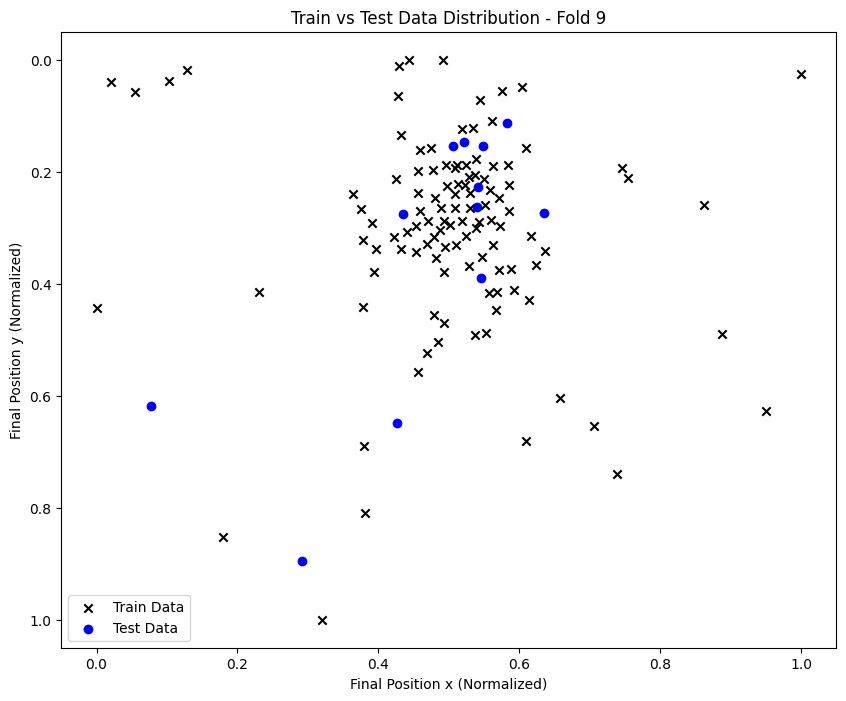

1/1 [==============================] - 0s 52ms/step


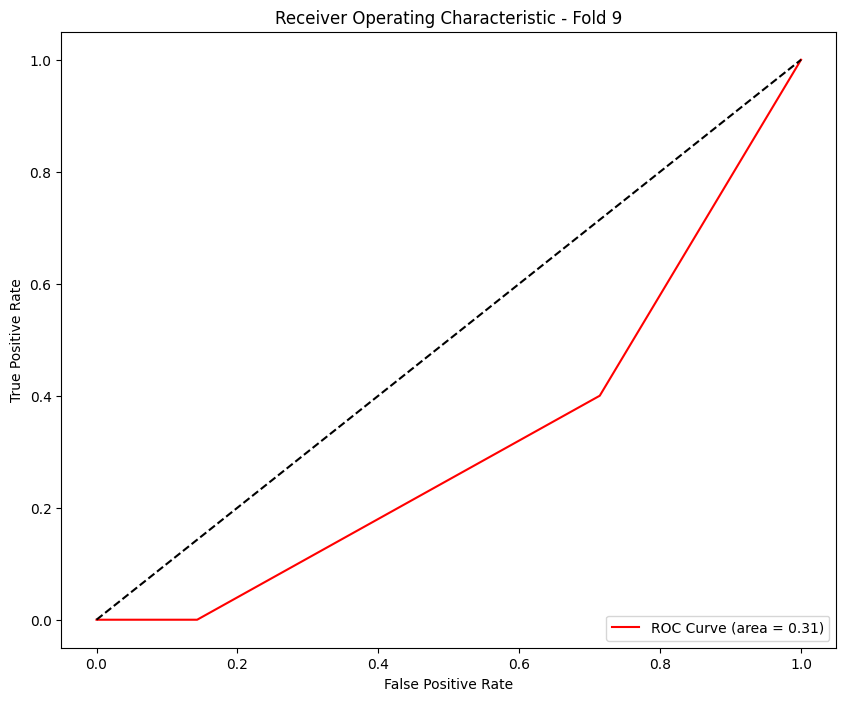

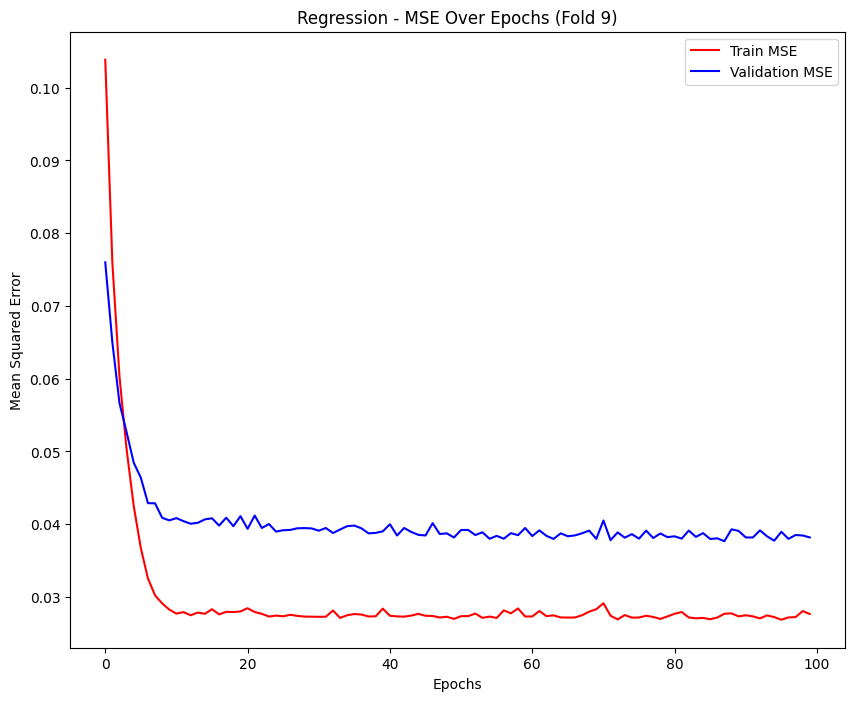

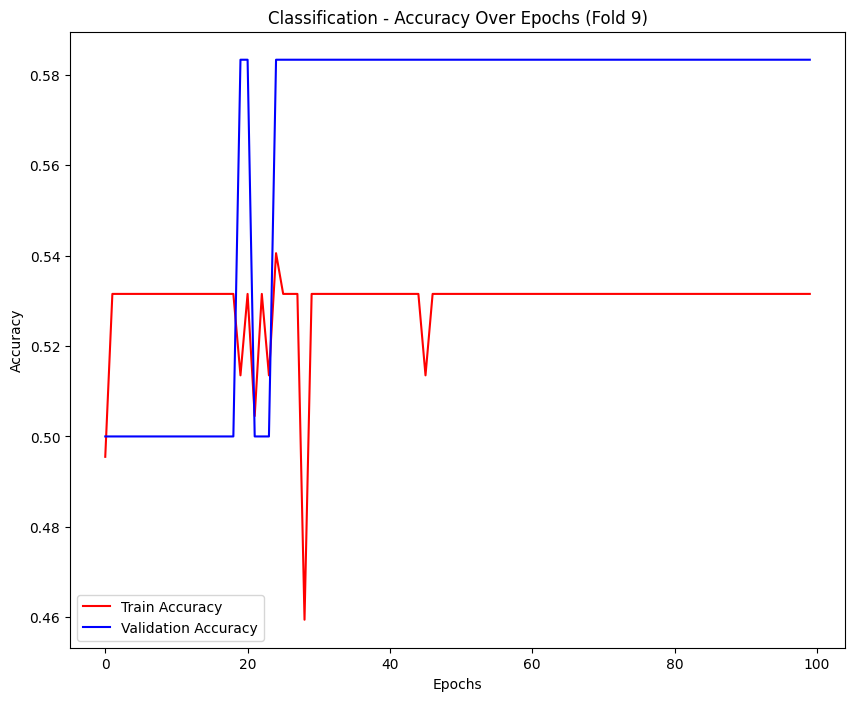

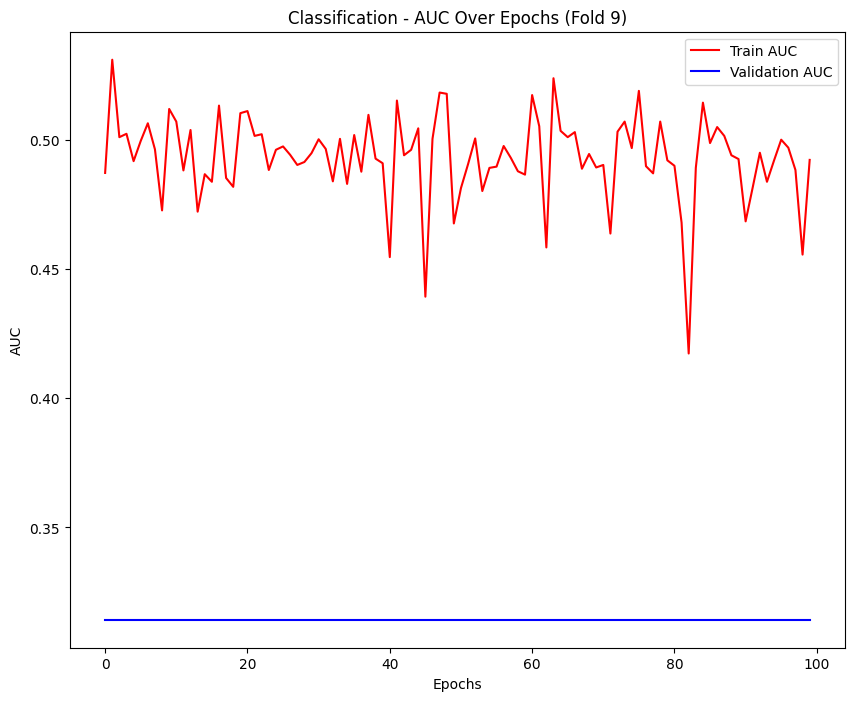

1/1 [==============================] - 0s 15ms/step
Fold 9 - Classification Report:
              precision    recall  f1-score   support

       Heads       0.58      1.00      0.74         7
       Tails       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

1/1 [==============================] - 0s 14ms/step
Fold 9 - Confusion Matrix:
[[7 0]
 [5 0]]
1/1 [==============================] - 0s 14ms/step
Fold 9 - Classification Predictions Comparison:
    Initial State  Actual Label  Predicted Label  Probabilistic Output
0             1.0           0.0              0.0              0.459197
1             1.0           1.0              0.0              0.459197
2             1.0           1.0              0.0              0.459197
3             1.0           0.0              0.0              0.459197
4             1.0           0.0         

/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluating the model (model.evaluate)...


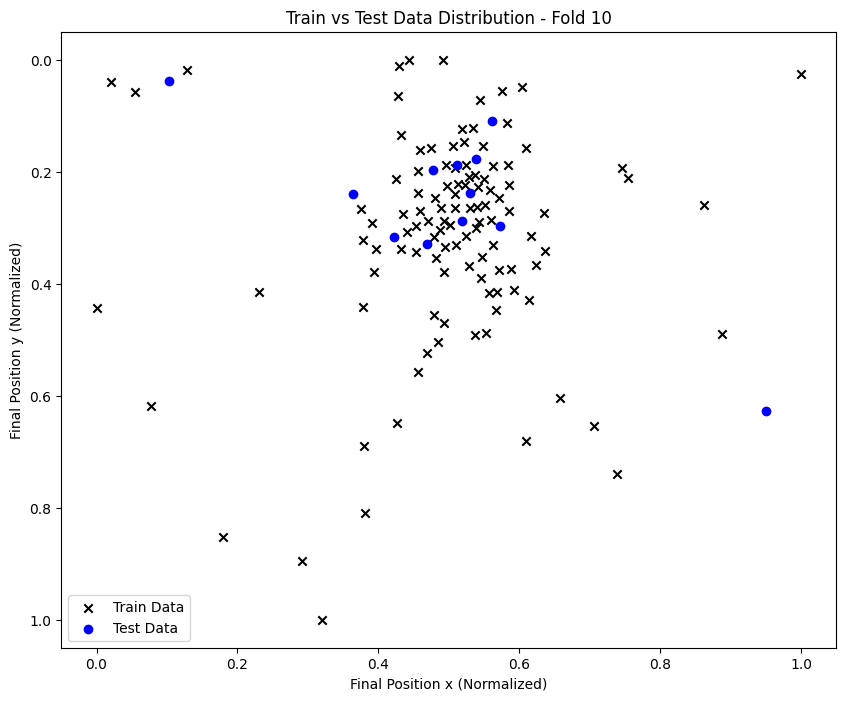

1/1 [==============================] - 0s 52ms/step


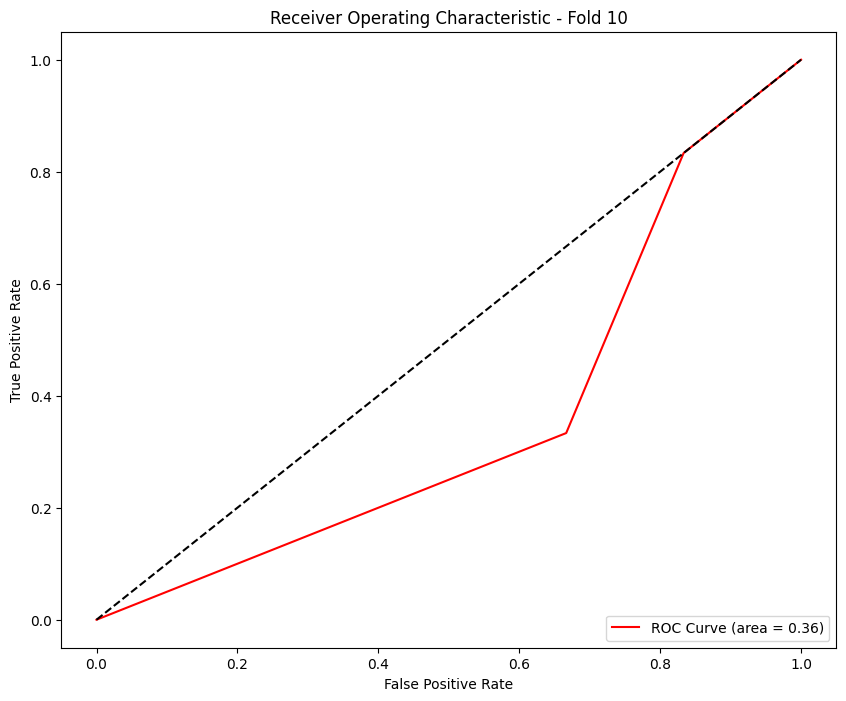

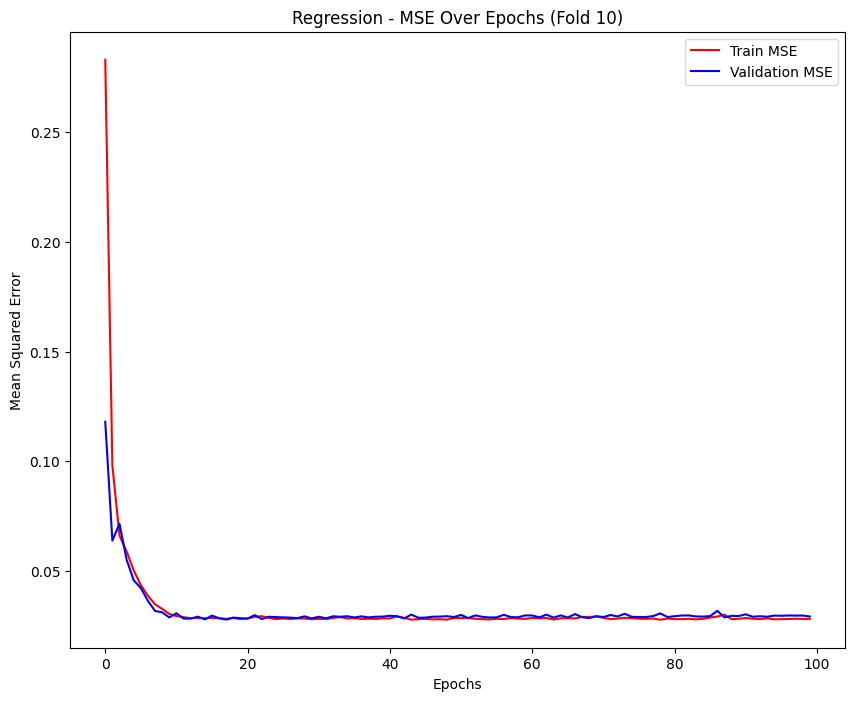

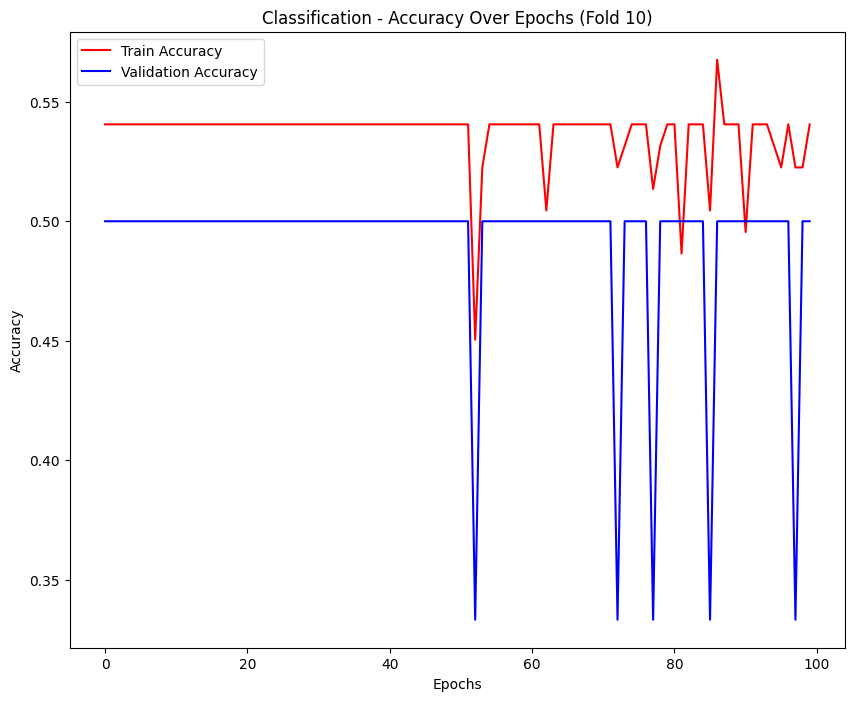

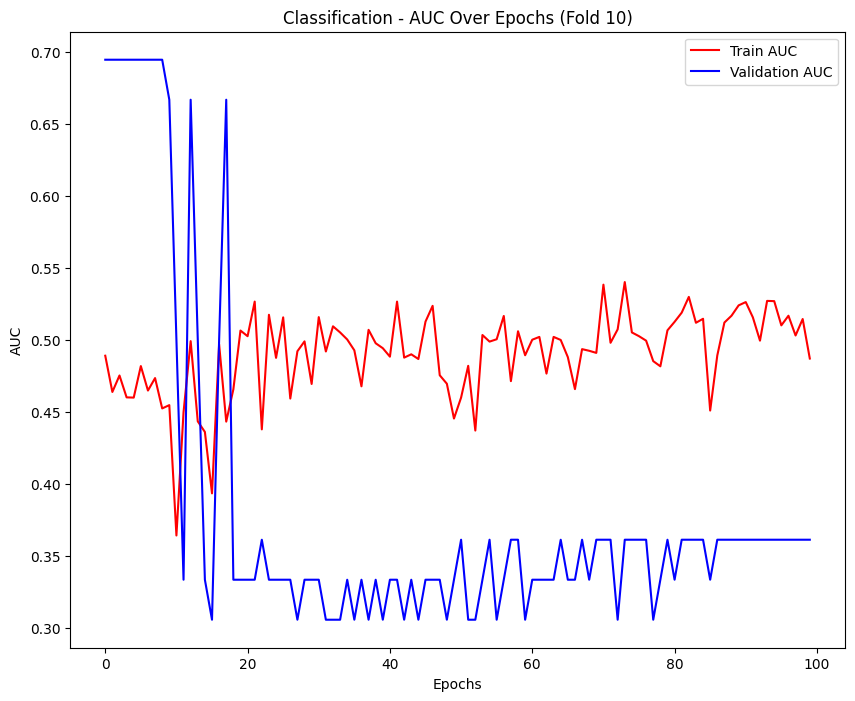

1/1 [==============================] - 0s 16ms/step
Fold 10 - Classification Report:
              precision    recall  f1-score   support

       Heads       0.50      1.00      0.67         6
       Tails       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

1/1 [==============================] - 0s 15ms/step
Fold 10 - Confusion Matrix:
[[6 0]
 [6 0]]
1/1 [==============================] - 0s 18ms/step
Fold 10 - Classification Predictions Comparison:
    Initial State  Actual Label  Predicted Label  Probabilistic Output
0             1.0           1.0              0.0              0.437415
1             1.0           0.0              0.0              0.437415
2             0.0           1.0              0.0              0.448173
3             0.0           1.0              0.0              0.448173
4             0.0           0.0      

/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egedemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, roc_curve, auc, classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Load and preprocess the dataset
data_path = 'experiment_data.csv'
coin_data = pd.read_csv(data_path)

# Encode categorical data
encoder = LabelEncoder()
coin_data['Initial'] = encoder.fit_transform(coin_data['Initial'])
coin_data['Final Heads or Tails'] = encoder.fit_transform(coin_data['Final Heads or Tails'])

# Separate features and targets
X = coin_data[['Initial']].values  # Only use 'Initial' as feature to avoid data leakage
y_class = coin_data['Final Heads or Tails'].values  # Classification target

# Scale the target variables for regression separately
scaler = MinMaxScaler()
scaler_y = MinMaxScaler()
y_reg = scaler.fit_transform(coin_data[['Final Position x', 'Final Position y']].values)  # Regression targets


# Define K-Fold Cross Validator and Model Creation Function
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

def create_model():
    # Model architecture
    print("Creating the model...")
    input_layer = Input(shape=(X.shape[1],))
    shared_dense1 = Dense(64, activation='relu')(input_layer)
    shared_dense2 = Dense(64, activation='relu')(shared_dense1)
    classification_output = Dense(1, activation='sigmoid', name='class_output')(shared_dense2)
    regression_output = Dense(2, activation='linear', name='reg_output')(shared_dense2)
    # Compile the model
    model = Model(inputs=input_layer, outputs=[classification_output, regression_output])
    print("Compiling the model (model.compile)...")
    model.compile(optimizer='adam',
              loss={'class_output': 'binary_crossentropy', 'reg_output': 'mean_squared_error'},
              metrics={'class_output': ['accuracy', AUC(name='auc')], 'reg_output': ['mse']}) 
    return model

# 10-Fold Cross-Validation with Enhanced Metrics and Visualization
fold_no = 1
for train, test in kfold.split(X):  # Split based only on the feature matrix X
    print(f"\n--- Processing Fold {fold_no} ---")
    model = create_model()
    print("Training the model (model.fit)...")

    # Fit the model using both classification and regression targets    
    history = model.fit(X[train], {'class_output': y_class[train], 'reg_output': y_reg[train]},
                        validation_data=(X[test], {'class_output': y_class[test], 'reg_output': y_reg[test]}),
                        epochs=100, batch_size=8, verbose=0)
    
    print("Evaluating the model (model.evaluate)...")
    scores = model.evaluate(X[test], {'class_output': y_class[test], 'reg_output': y_reg[test]}, verbose=0)


    # Define paths for saving the plots
    classification_plot_path = 'classification_plots'
    regression_plot_path = 'regression_plots'
    general_visualizations_path = 'general_visualizations_of_folds'

    # Create directories if they don't exist
    os.makedirs(classification_plot_path, exist_ok=True)
    os.makedirs(regression_plot_path, exist_ok=True)
    os.makedirs(general_visualizations_path, exist_ok=True)

    # Supporting functions for visualizations and metrics calculations
    visualize_data(y_reg, train, test, fold_no)
    visualize_roc_curve(model, y_class, test, fold_no)
    plot_regression_metrics(history, fold_no)
    plot_classification_accuracy(history, fold_no)
    plot_auc(history, fold_no)
    generate_classification_report(model, y_class, test, fold_no)
    print_confusion_matrix(model, X, y_class, test, fold_no)
    classification_comparison_df = compare_classification_predictions(model, X, y_class, test, fold_no)
    regression_comparison_df = compare_regression_predictions(model, X, y_reg, test, scaler, fold_no)
 
    # Print evaluation results
    print(f"\nScores for Fold {fold_no}:")
    for name, value in zip(model.metrics_names, scores):
        print(f"  - {name}: {value}")
    selected_no = 4
    if fold_no == selected_no:
        classification_comparison_df = compare_classification_predictions(model, X, y_class, test, fold_no=selected_no)
        regression_comparison_df = compare_regression_predictions(model, X, y_reg, test, fold_no=selected_no,scaler=scaler)
        visualize_classification_comparisons(classification_comparison_df, fold_no=selected_no)
        visualize_regression_comparisons(regression_comparison_df, X, y_reg, test, scaler, fold_no=selected_no)
    fold_no += 1

    

In [5]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 64)           128         ['input_10[0][0]']               
                                                                                                  
 dense_19 (Dense)               (None, 64)           4160        ['dense_18[0][0]']               
                                                                                                  
 class_output (Dense)           (None, 1)            65          ['dense_19[0][0]']               
                                                                                            

In [6]:
model.save('10_fold_model.h5')

In [7]:
print(history.history.keys())

dict_keys(['loss', 'class_output_loss', 'reg_output_loss', 'class_output_accuracy', 'class_output_auc', 'reg_output_mse', 'val_loss', 'val_class_output_loss', 'val_reg_output_loss', 'val_class_output_accuracy', 'val_class_output_auc', 'val_reg_output_mse'])


In [8]:
from sklearn.preprocessing import LabelEncoder
labels = ['Heads', 'Tails'] 
encoder = LabelEncoder()
encoder.fit(labels)

# Mapping from label to numeric value
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label to Numeric Mapping:", label_mapping)


Label to Numeric Mapping: {'Heads': 0, 'Tails': 1}


In [9]:
import pandas as pd

# Assuming 'coin_data' is your DataFrame and it has columns 'Final Position x' and 'Final Position y'
range_x = coin_data['Final Position x'].max() - coin_data['Final Position x'].min()
range_y = coin_data['Final Position y'].max() - coin_data['Final Position y'].min()

std_dev_x = coin_data['Final Position x'].std()
std_dev_y = coin_data['Final Position y'].std()

print(f"Range of X: {range_x}, Standard Deviation of X: {std_dev_x}")
print(f"Range of Y: {range_y}, Standard Deviation of Y: {std_dev_y}")


Range of X: 4851, Standard Deviation of X: 738.3479933583361
Range of Y: 2486, Standard Deviation of Y: 466.9989936919452
